# Tarea 1: Optimización de problemas de mediana escala

**EL4114 - Optimización**  
**Otoño 2025**  
**Profesor:** Rodrigo Moreno  
**Auxiliar:** Daniel Águila    
**Ayudantes:** Diego González - Yerko Orellana - Agustín Vilches \\
**Yo:** Eduardo Ríos

## Instrucciones

*   La tarea se debe resolver de forma **individual.** No obstante, puede discutir con sus compañero/as estrategias para implementar la solución.
*   El código escrito debe ser únicamente de su autoría. Cualquier fuente externa utilizada debe ser citada claramente en las referencias al final de este Notebook. Aún así, el uso de sitios de consulta como *StackOverflow*, *TowardsDataScience*, etc. está permitido manteniendo en un nivel prudente la cantidad de código que utiliza proveniente de ellos.
*   Cualquier plagio entre códigos de las soluciones enviadas por los estudiantes será penalizado y la situación revisada por el cuerpo docente del curso.
*   Se recomienda fuertemente comentar el código para un mejor entendimiento en la corrección.
*   Verifique antes de realizar su última entrega que el código efectivamente se puede ejecutar. Si algún bloque de código o el código completo no se ejecuta, no lo entregue ya que todo bloque que no se ejecute no será corregido.
* Sea claro en sus resultados y comentarios. Al graficar no olvide incluir los nombres de los ejes, título, leyendas, etc.
* Los archivos con datos entregados por el equipo docente **no deben ser modificados**. Las pruebas del código serán realizadas con los archivos originales.
* Antes de resolver la tarea, es altamente recomendable que revise la clase auxiliar extra realizada ya que le será de utilidad para implementar el código con mayor facilidad.

## Formato de entrega

* En cada pregunta se incluyen bloques en blanco para programar sus soluciones. Esta es solo una recomendación de estructura. Usted puede implementar su código como le sea conveniente, siempre que este sea ejecutable y entendible.
* Para que su entrega sea corregida, entregue a través de U-Cursos el archivo .ipynb
* No es necesario que redacte un informe aparte. Todas las respuestas, comentarios, gráficos, ecuaciones, etc. deben ser incluidas en este documento

## Librerías

In [7]:
#!apt-get install -y -qq glpk-utils

In [8]:
# Se cargan las librerías mínimas a usar.
from pyomo.environ import *      # Esta es la librería para optimizar
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  

# Problema de despacho económico/predespacho

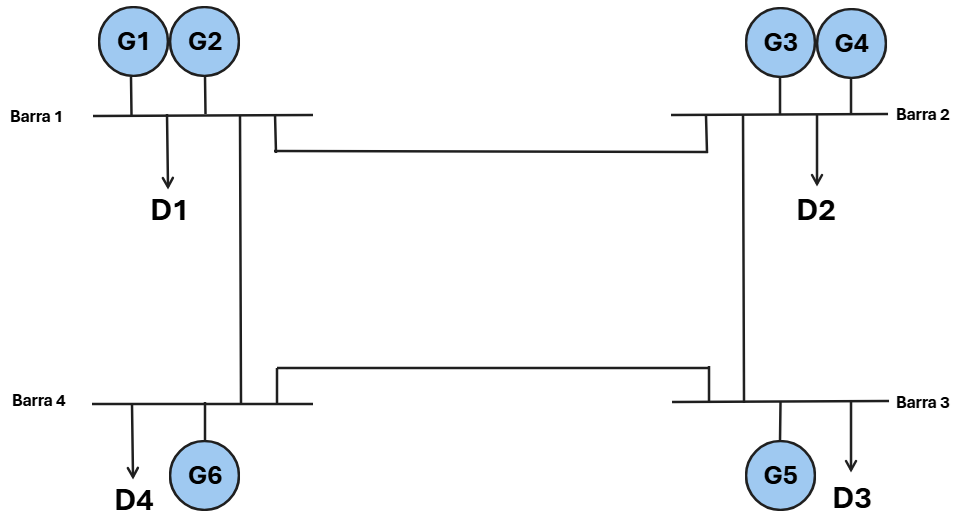![Red para el problema de despacho](Red.png)

A continuación se muestra una red eléctrica de 4 barras, 6 generadores, 4 líneas de transmisión y 4 demandas. El objetivo del problema de despacho económico es suministar energía desde los generadores hacia las demandas a mínimo costo, para las 24 horas del día. Los datos del problema se encuentran en la hoja de datos adjunta.

## Carga de datos

In [9]:
Data = 'Data/Datos_T1.xlsx'
Dems, Gens, Lins, PerS, PerE = pd.read_excel(Data, sheet_name=['Demandas', 'Generadores', 'Líneas', 'Perf_Sol', 'Perf_Eol']).values()

### Generadores

In [10]:
Gens

,ID,Barra,Tecnología,P_Min,P_Max,CV,C_on,C_off,R_up,R_down
0,1,1,Car,25,260,50,44955,22478,25,25
1,2,1,Gas,20,220,100,17551,8776,16,16
2,3,2,Car,20,210,40,36309,18155,20,20
3,4,2,Die,10,110,150,16034,8017,75,75
4,5,3,Sol,0,100,0,0,0,100,100
5,6,4,Eol,0,150,0,0,0,100,100


### Líneas

In [11]:
Lins

,ID,From,To,F_Max,Reactancia
0,1,1,2,100,0.05
1,2,2,3,150,0.01
2,3,3,4,100,0.02
3,4,4,1,100,0.03


### Demandas

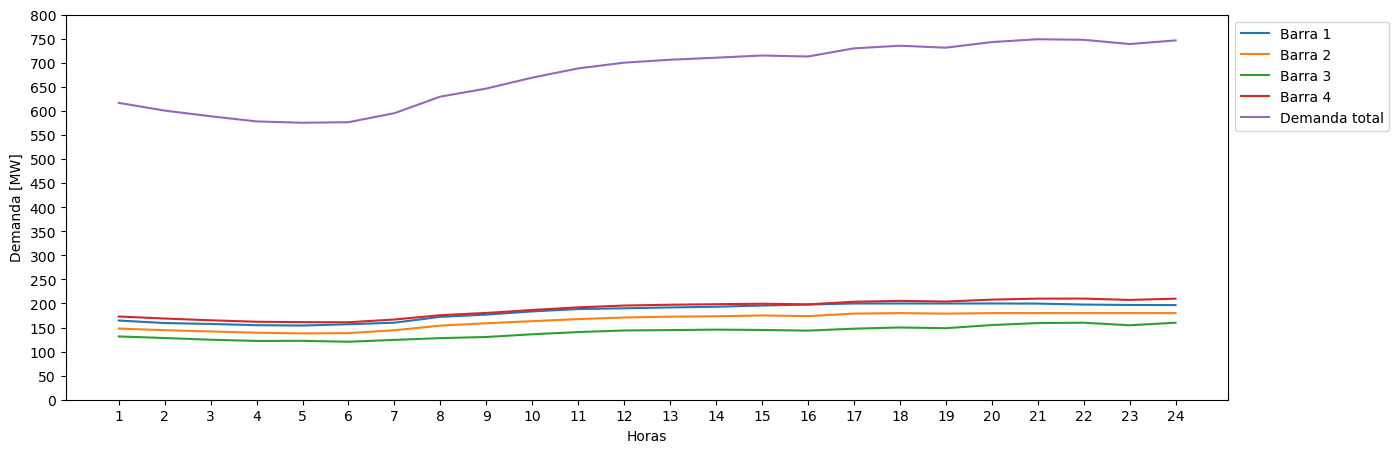

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(range(1,25),Dems.iloc[:,0],label='Barra 1')
plt.plot(range(1,25),Dems.iloc[:,1],label='Barra 2')
plt.plot(range(1,25),Dems.iloc[:,2],label='Barra 3')
plt.plot(range(1,25),Dems.iloc[:,3],label='Barra 4')
plt.plot(range(1,25),Dems.sum(axis=1),label='Demanda total')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(np.arange(1,25,1))
plt.yticks(np.arange(0,801,50))
plt.xlabel('Horas')
plt.ylabel('Demanda [MW]')
plt.show()

### Perfiles

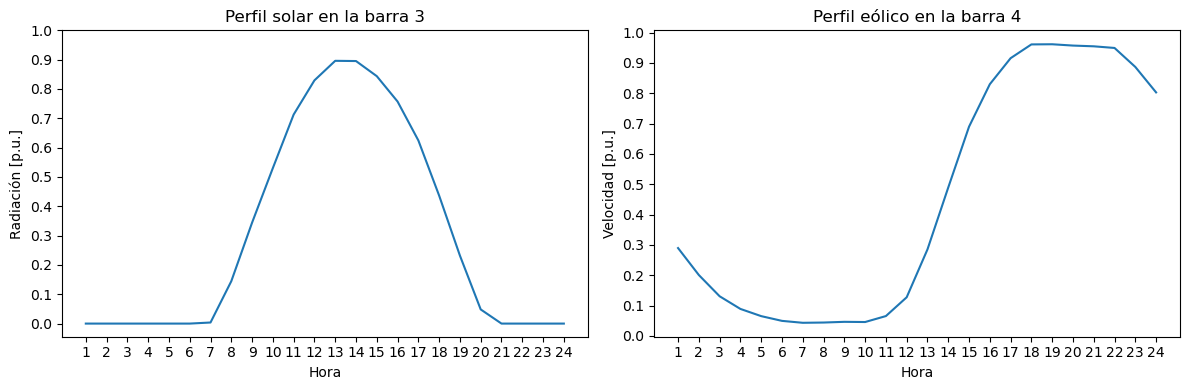

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Perfil solar
axs[0].plot(range(1,25), PerS.iloc[:, 0])
axs[0].set_yticks(np.arange(0, 1.1, 0.1))
axs[0].set_ylabel('Radiación [p.u.]')
axs[0].set_xticks(np.arange(1, 25, 1))
axs[0].set_xlabel('Hora')
axs[0].set_title('Perfil solar en la barra 3')

# Perfil eólico
axs[1].plot(range(1,25), PerE.iloc[:, 0])
axs[1].set_yticks(np.arange(0, 1.1, 0.1))
axs[1].set_ylabel('Velocidad [p.u.]')
axs[1].set_xticks(np.arange(1, 25, 1))
axs[1].set_xlabel('Hora')
axs[1].set_title('Perfil eólico en la barra 4')

plt.tight_layout()
plt.show()


## Indicaciones

A continuación, se entregarán algunos tips que le servirán de guía para desarrollar el modelamiento del problema de **despacho económico/predespacho** (nos referimos específicamente a predespacho por las variables binarias de encendido/apagado asociadas a las unidades de generación térmicas). Para modelar los flujos de potencia por las líneas utilizaremos la modalidad DC o de flujo lineal, tal como se vio en el auxiliar computacional, el cual fue online.

### Acerca de la infraestructura de la red

* **Características técnicas de los generadores**
Los generadores térmicos poseen una potencia mínima, debido a que bajo cierto punto de operación las temperaturas y presiones pueden volverse inestables, además de una capacidad máxima (véase la hoja Generadores, columnas P_Min y P_Max, cuyos valores están en MW), mientras que los generadores renovables pueden operar desde cero hasta su cacpacida máxima. Por otro lado, los generadores no pueden aumentar o disminuir su generación de forma instantánea, es decir, la diferencia entre la potencia que generan en el periodo $t$ y en el $t+1$ no puede superar cierto valor. Este valor se llama Rampa y existen rampas de subida como rampas de bajada (véase la hoja Generadores, columnas R_up y R_down, cuyos valores están en MW/h). En general, las rampas de las unidades térmicas son bajas en comparación a su capacidad, debido a la inercia térmica (sólo las centrales Diésel poseen rampas altas). Sin embargo, en las unidades renovables, la rampa es alta en comparación a su capacidad, debido a que el recurso que utilizan no posee esta inercia térmica.

* **Generadores renovables**
A diferencia de los generadores térmicos, la disponibilidad del recurso para generar energía no es total en los generadores renovables. En generadores solares y eólicos, la disponibilidad del recurso depende de la radiación solar y de la velocidad del viento respectivamente. Para poder predecir cuánta energía puede producir un generador renovable, se hace un pronóstico que se traduce en un "Perfil" (véase las hojas Perf_Sol y Perf_Eol, cuyos valores están en p.u.). Los perfiles son números entre 0 y 1 que representan cuánto de la capacidad instalada es capaz de producir el generador en cierta hora. Así, la potencia que generan las renovables está acotada superiormente por la multiplicación entre su capacidad y el perfil.

* **Barras y demandas**
En un sistema eléctrico, las barras son los puntos del sistema donde las unidades de generación (generadores) y las cargas (demanda) se conectan a la red eléctrica. Observe que en la hoja Generadores, cada generador tiene una barra asignada, mientras que, en la hoja Demandas, el header indica el número de la barra a la cual corresponden los valores de demanda en cada hora en MW.

* **Líneas de transmisión**
Las líneas de transmisión, permiten que la energía sea transportada desde las zonas de generación hasta las zonas de consumo. Por facilidad en la modelación, es usual asignarle una dirección a las líneas: de la barra 'From' a la barra 'To' (véase estas columnas en la hoja de datos). Además, en alta tensión, no es relevante la impedancia completa de la línea, sino que sólo su reactancia (también disponible en la hoja Líneas, cuyos valores están en p.u.). Finalmente, las líneas tienen una capacidad máxima de flujo (F_Max en la hoja Líneas, en MW). Por comodidad, el flujo por la línea $l$ en un tiempo $t$ se suele acotar entre $-F_{Max}$ y $F_{Max}$ para modelar que el flujo puede ir en ambas direcciones. Si el flujo es positivo, es porque va en la dirección de "From" a "To" y si es negativo, es porque va al revés.

### Acerca de los costos

* **Costos de producción (costos variables)**  
La producción de una unidad de energía de un generador térmico tiene un costo variable igual al **costo del combustible** utilizado para la producción de cada unidad de energía. Como el combustible de las centrales solares y eólicas es gratis, sus costos variables son **cero** (véase la hoja Generadores, columna CV, cuyos valores están en $USD/MWh$).

* **Costos de encendido y apagado**  
Los generadores térmicos incurren en un costo al encenderse, $c^{E}$,  ya que requieren quemar combustible sólo para calentar el sistema lo suficiente antes de generar energía. También, incurren un gasto al apagarse, $c^{A}$, ya que este es un complejo proceso que utiliza tiempo, recursos y combustible. Note que las unidades renovables no incurren en estos costos, ya que no utilizan combustible (véase la hoja Generadores, columnas C_on y C_off, cuyos valores están en $USD$). Para modelar la decisión de encendido y apagado se proponen las variables binarias $X^\text{ON}_{g,t}$ y $X^\text{OFF}_{g,t}$: $X^\text{ON}_{g,t}$ toma el valor 1 si el generador $g$ se enciende en el instante $t$ y toma el valor 0 en caso contrario, mientras que $X^\text{OFF}_{g,t}$ toma el valor 1 si el generador $g$ se apaga en el instante $t$ y toma el valor 0 en caso contrario.  

* **Costos totales del sistema**
El objetivo del despacho económico es **minimizar los costos totales del sistema**, los que corresponden a la suma de los costos de producción, costos de encendido y costos de apagado de los generadores.

### Otras consideraciones técnicas

* **Balance potencia en cada nodo**  
Para evitar fallas en la estabilidad del sistema, la suma de las potencias inyectadas en una barra debe ser igual a las potencias retiradas, por lo tanto, se debe asegurar un balance entre carga y generación en cada nodo. Matemáticamente, se debe asegurar que la suma de las potencias que los generadores inyectan en la barra $b$ más los flujos de potencia que entran a la barra $b$ por las líneas de transmisión, sea igual a la demanda en la barra $b$ más los flujos de potencia que salen de la barra $b$.

* **Flujo DC**  
Existe una forma simplificada de escribir el flujo de potencia activa por una línea de transmisión cuando se trata de problemas de alta tensión, llamada "Flujo DC". Esta simplificación asume que en barras adyacentes los voltajes son prácticamente iguales, las pérdidas resistivas son despreciables y las diferencias angulares entre los ángulos de voltaje es pequeña. Así, el flujo de potencia activa en la línea $l$, en función de los ángulos de voltaje en las barras $\theta$ y su reactancia $X_l$, se expresa como:

$$ f_{l} = \dfrac{\theta^{From}_{l}-\theta^{To}_{l}}{X_{l}}$$

* **Desconexión de carga/demanda**  
Algunas veces, no es posible cumplir con las restricciones de balance de potencia, debido a que el sistema se encuentra en un estado de contingencia producto de la falla de alguno(s) de sus componentes, o simplemente, debido a una mala planificación de la infraestructura. Matemáticamente, si la restricción de balance no se cumple, el problema sería infactible. Sin embargo, en casos extremos es necesario resolver el problema de todas formas, permitiendo que la restricción de balance no se cumpla o, en otras palabras, permitiendo que exista demanda no suministrada. Para esto, se crea una nueva variable $D_{bt}^{NS}$ que modela la demanda que no se suministra en la barra $b$ en la hora $t$. Para integrar esta variable a la restricción de balance, basta con restarla a la demanda de cada barra. Para evitar que el modelo entregue como resultado grandes cantidades de demanda no suministrada, a esta se le asigna un costo altísimo llamado VoLL (Value of Lost Load) que en este caso será de $1000$ $USD/MWh$ y **debe ser agregado en la función objetivo**

* **Encendido, apagado y generación**  
Es necesario asegurarse de que los generadores inyecten potencia sólo cuando están encendidos. Por este motivo se sugiere incorporar la variable binaria $X^E_{g,t}$ que indique el "estado" del generador $g$ en la hora $t$. Esta variable será igual a 1 si el generador $g$ está encendido en la hora $t$ y 0 cuando esté apagado. Note que esta variable de estado debe ser consistente con con $X^\text{ON}_{g,t}$ y $X^\text{OFF}_{g,t}$ (ver la sección siguiente).

*  **Conmutación de generadores**  
Para modelar el estado del generador $g$, se debe incluir una restricción que relacione el estado en la hora actual, $X^E_{g,t}$, el estado en la hora anterior $X^E_{g,t-1}$, y el encendido y apagado en la hora actual: $X^\text{ON}_{g,t}$ y $X^\text{OFF}_{g,t}$. Para lo anterior, solo existirán cuatro combinaciones posibles, las cuales debe considerar para modelar la restricción:

  \begin{array}{|c|c|}
X^E_{g,t} & X^E_{g,t-1} & X^\text{ON}_{g,t} &X^\text{OFF}_{g,t} \\ \hline
0 & 0 & 0 & 0 \\
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
1 & 1 & 0 & 0 \\ \hline
\end{array}
  >
  > **Observación:** La combinación $ 1 \ 1 \ 1 \ 1$ no es incluida ya que no es posible que un generador sea encendido y apagado en la misma hora $t$.  
>

# Parte A

Formule el problema de despacho económico considerando **sólo los costos variables y de demanda no suministrada** (no considere costos de encendido y apagado). Tampoco considere la restricción de rampa. Recuerde que para que un problema de optimización esté bien definido debe declarar: índices, conjuntos, parámetros, variables, función objetivo y restricciones. Comente cada una de ellas.

## Indices


*   $b$: Barras del sistema
*   $g$: Generadores
*   $l$: Lineas de transmisión
*   $t$: Periodos de tiempo

## Conjuntos

* $B$: Barras del sistema
* $G$: Generadores
* $L$: Lineas de transmisión
* $T$: Periodos de tiempo
* $G_b$: Generadores conectados a la barra $b$
* $From_b$: Líneas que salen de la barra $b$
* $To_b$: Líneas que llegan a la barra $b$

## Parámetros

* $D_{bt}$: Demanda en la barra b en el tiempo t
* $\bar{P}_g$: Capacidad del generador g
* $\pi_g$: Costo variable del generador g
* $\underline{P}_g$: Potencia mínima que puede entregar el generador g
* $Voll$: Valor de demanda perdida
* $\bar{F}_l$: Flujo máximo soportado por la linea l
* $X_l$: Reactancia de la linea l
* $Disp_{gt}$: Potencia máxima relativa disponible del generador g en el tiempo

## Variables


* $f_{lt}$: Flujo por la línea $l$ en el periodo $t$  
* $P_{gt}$: Potencia despachada por el generador $g$ en el periodo $t$  
* $\theta_{lt}^{From}$: Ángulo de voltaje de la barra $From$ de la línea $l$ en
  el periodo $t$  
* $\theta_{lt}^{To}$: Ángulo de voltaje de la barra $To$ de la línea $l$ en el
  periodo $t$
* $D_{bt}^{NS}$: Desconección de carga/demanda  

## Problema de optimización

$$ \min \sum_{t\in T} \sum_{g\in G} P_{gt} \pi_g + \sum_{t\in T} \sum_{b\in B} D_{bt}^{NS}Voll $$
$$s.a:  \sum_{g \in G_b} P_{gt} + \sum_{l \in From_n} f_{lt} = D_{bt} - D_{bt}^{NS} + \sum_{l \in To_n} f_{lt}, \qquad \forall b \in B, \forall t \in T $$
$$ \underline{P}_g X^{E}_{gt} \leq P_{gt} \leq \bar{P}_g Disp_{gt}, \qquad \forall g \in G, \forall t \in T $$
$$ -\bar{F}_l \leq f_{lt} \leq \bar{F}_l, \qquad \forall l \in L, \forall t \in T$$
$$ f_{lt} = \dfrac{\theta^{From}_{lt}-\theta^{To}_{lt}}{X_{l}}, \qquad \forall l \in L, \forall t \in T $$
$$P_{gt} \leq X^{E}_{gt}\bar{P}_g, \qquad \forall g \in G, \forall t \in T $$
$$X^{E}_{g,t} - X^{E}_{g,t-1} = X^\text{ON}_{g,t} - X^\text{OFF}_{g,t} , \qquad \forall g \in G, \forall t \in T$$
$$X^\text{ON}_{g,t} + X^\text{OFF}_{g,t} \leq 1, \qquad \forall g \in G, \forall t \in T$$

Arriba se muestra el modelo seguido para resolver la Parte A. A continuación se explicará brevemente cada expresión:

* Función objetivo: El primer término es la suma de las potencias generadas por cada generador en cada tiempo por el costo variable de cada generador. El segundo término es la suma de la demanda no suministrada en cada barra y en cada tiempo por Voll = 1000 USD/MWh.

* Primera restricción: corresponden al balance de potencias entrantes y salientes de cada nodo.

* Segunda restricción: Corresponde a las cotas superiores e inferiores de la potencia generada por cada generador en cada tiempo. Notar que la cota inferior corresponde a la potencia mínima que puede suminstrar cada generador por la variable de estado (Es importante múltipliar por el estado, pues de otro modo los generadores no se podrían apagar). Por otro lado, la cota superior es la potencia máxima que puede entregar cada generador multiplicado por una matriz de disponibilidad, la cual contiene la información sobre el perfil eólico y solar de los generadores renovables, mientras que para los no renovables, los múltiplica por 1.

* Tercera restricción: Restringe el flujo que puede pasar por cada línea, de modo que no supere su capacidad máxima.

* Cuarta restricción: Corresponde al flujo de potencia que pasa por una línea entre barras adyacentes.

* Quinta restricción: Es idéntica a la cota superior de la segunda, pero se múltiplica por la variable de estado, de modo que la potencia máxima que puede entregar cada generador en cada tiempo t es 0, si en el instante t el generador está apagado.

* Sexta restricción: Corresponde la relación de conmutación que deben cumplir los generadores.

* Séptima restricción: Impide que para un mismo tiempo, un generador se encienda y se apague.

# Parte B

Resuelva el problema formulado en la **Parte A** usando Pyomo, comentando cada uno de sus conjuntos, parámetros, variables, función objetivo y restricciones.
* Muestre el despacho de potencias para cada hora en un gráfico de áreas apiladas, los flujos por las líneas de transmisión indicando los límites de cada línea y las binarias de estado para cada generador.
* ¿Hay demanda no suministrada? Explique la diferencia entre su gráfico de áreas y el de demanda total si es que la hubiera.
* No olvide indicar el costo de la función objetivo.

## Creación del modelo

In [14]:
# Creación del modelo
m_A = ConcreteModel()

## Conjuntos

In [15]:
m_A.Barras      = Set(initialize=range(1,5))
m_A.Generadores = Set(initialize=Gens.ID.tolist())
m_A.Lineas      = Set(initialize=Lins.ID.tolist())
m_A.Horas       = Set(initialize=range(24))

In [16]:
#Comprabamos si están bien los conjuntos
#print(list(m_P2.Horas.data()))

## Parámetros

In [17]:
# Creación de diccionarios para acceder más fácilmente a los parámetros del problema
m_A.Pmax       = Param(m_A.Generadores, initialize=Gens.set_index("ID")["P_Max"].to_dict())
m_A.CV         = Param(m_A.Generadores, initialize=Gens.set_index("ID")["CV"].to_dict())
m_A.BarraGen   = Param(m_A.Generadores, initialize=Gens.set_index("ID")["Barra"].to_dict())
m_A.Fmax       = Param(m_A.Lineas, initialize=Lins.set_index("ID")["F_Max"].to_dict())
m_A.Reactancia = Param(m_A.Lineas, initialize=Lins.set_index("ID")["Reactancia"].to_dict())
m_A.From       = Param(m_A.Lineas, initialize=Lins.set_index("ID")["From"].to_dict())
m_A.To         = Param(m_A.Lineas, initialize=Lins.set_index("ID")["To"].to_dict())
m_A.Pmin       = Param(m_A.Generadores, initialize=Gens.set_index("ID")["P_Min"].to_dict())
m_A.Voll       = 1000

demanda_dict = {(b, h): Dems.loc[h, b] for h in range(24) for b in [1, 2, 3, 4]}
m_A.Demanda = Param(m_A.Barras, m_A.Horas, initialize=demanda_dict)

#Creamos una matriz de 6 x 24 para las potencias maximas entregadas por cada generador
Matrix_1 = np.ones(24, dtype=int)
PerSol = PerS.iloc[:, 0].values
PerEol = PerE.iloc[:, 0].values
Matrix_2 = [Matrix_1, Matrix_1, Matrix_1, Matrix_1, PerSol, PerEol]
disp = pd.DataFrame(Matrix_2, index=range(1,7))
#Ahora hagamos el dccionario para el modelo
disp_dict = {(g, h): disp.loc[g, h] for h in range(24) for g in [1, 2, 3, 4, 5, 6]}
m_A.Disponibilidad = Param(m_A.Generadores, m_A.Horas, initialize=disp_dict)

### Pruebas Parametros

In [18]:
m_A.Disponibilidad[6,0]
#m_A.Demanda[1,0]

np.float64(0.289510628382189)

In [19]:
demanda_dict

{(1, 0): np.float64(164.55363605670954),
 (2, 0): np.float64(147.84571126350707),
 (3, 0): np.float64(131.5154150477371),
 (4, 0): np.float64(172.9529420354997),
 (1, 1): np.float64(159.34753623674354),
 (2, 1): np.float64(144.5254720898953),
 (3, 1): np.float64(128.2120200450689),
 (4, 1): np.float64(168.6855825008527),
 (1, 2): np.float64(157.43929480823914),
 (2, 2): np.float64(141.80102666168008),
 (3, 2): np.float64(124.65531987099672),
 (4, 2): np.float64(165.07410656723042),
 (1, 3): np.float64(154.86977597216165),
 (2, 3): np.float64(139.2449987442066),
 (3, 3): np.float64(122.16836911392889),
 (4, 3): np.float64(162.01281990534997),
 (1, 4): np.float64(154.13226586940831),
 (2, 4): np.float64(137.80629361772017),
 (3, 4): np.float64(122.37823122503734),
 (4, 4): np.float64(161.20558160603755),
 (1, 5): np.float64(156.85548168401132),
 (2, 5): np.float64(138.3708501309241),
 (3, 5): np.float64(120.52008444778284),
 (4, 5): np.float64(160.94861317157108),
 (1, 6): np.float64(160

In [20]:
disp_dict

{(1, 0): np.float64(1.0),
 (2, 0): np.float64(1.0),
 (3, 0): np.float64(1.0),
 (4, 0): np.float64(1.0),
 (5, 0): np.float64(0.0),
 (6, 0): np.float64(0.289510628382189),
 (1, 1): np.float64(1.0),
 (2, 1): np.float64(1.0),
 (3, 1): np.float64(1.0),
 (4, 1): np.float64(1.0),
 (5, 1): np.float64(0.0),
 (6, 1): np.float64(0.200595322986289),
 (1, 2): np.float64(1.0),
 (2, 2): np.float64(1.0),
 (3, 2): np.float64(1.0),
 (4, 2): np.float64(1.0),
 (5, 2): np.float64(0.0),
 (6, 2): np.float64(0.130521514712439),
 (1, 3): np.float64(1.0),
 (2, 3): np.float64(1.0),
 (3, 3): np.float64(1.0),
 (4, 3): np.float64(1.0),
 (5, 3): np.float64(0.0),
 (6, 3): np.float64(0.088764932095513),
 (1, 4): np.float64(1.0),
 (2, 4): np.float64(1.0),
 (3, 4): np.float64(1.0),
 (4, 4): np.float64(1.0),
 (5, 4): np.float64(0.0),
 (6, 4): np.float64(0.0650151493257162),
 (1, 5): np.float64(1.0),
 (2, 5): np.float64(1.0),
 (3, 5): np.float64(1.0),
 (4, 5): np.float64(1.0),
 (5, 5): np.float64(0.0),
 (6, 5): np.float64

In [21]:
disp.head(6)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003670,0.144536,0.344168,0.530414,...,0.843706,0.757162,0.624537,0.436410,0.231813,0.048246,0.000000,0.000000,0.000000,0.000000
6,0.289511,0.200595,0.130522,0.088765,0.065015,0.049372,0.043025,0.043881,0.046202,0.045552,...,0.689800,0.829868,0.915701,0.961133,0.961626,0.957302,0.954858,0.949435,0.886844,0.802832


## Variables

In [22]:
# Variables
m_A.Pgen   = Var(m_A.Generadores, m_A.Horas, within=NonNegativeReals)
m_A.Flujo  = Var(m_A.Lineas, m_A.Horas, within=Reals)
m_A.Angulo = Var(m_A.Barras, m_A.Horas, within=Reals, bounds=(-3.14, 3.14))
m_A.Dns    = Var(m_A.Barras, m_A.Horas, within=NonNegativeReals)

m_A.X_ON   = Var(m_A.Generadores, m_A.Horas, within=Binary)
m_A.X_OFF  = Var(m_A.Generadores, m_A.Horas, within=Binary)
m_A.X_E    = Var(m_A.Generadores, m_A.Horas, within=Binary)




### Pruebas Variables

In [23]:
for i in m_A.Dns:
  print(f"Dns[{i}]")

Dns[(1, 0)]
Dns[(1, 1)]
Dns[(1, 2)]
Dns[(1, 3)]
Dns[(1, 4)]
Dns[(1, 5)]
Dns[(1, 6)]
Dns[(1, 7)]
Dns[(1, 8)]
Dns[(1, 9)]
Dns[(1, 10)]
Dns[(1, 11)]
Dns[(1, 12)]
Dns[(1, 13)]
Dns[(1, 14)]
Dns[(1, 15)]
Dns[(1, 16)]
Dns[(1, 17)]
Dns[(1, 18)]
Dns[(1, 19)]
Dns[(1, 20)]
Dns[(1, 21)]
Dns[(1, 22)]
Dns[(1, 23)]
Dns[(2, 0)]
Dns[(2, 1)]
Dns[(2, 2)]
Dns[(2, 3)]
Dns[(2, 4)]
Dns[(2, 5)]
Dns[(2, 6)]
Dns[(2, 7)]
Dns[(2, 8)]
Dns[(2, 9)]
Dns[(2, 10)]
Dns[(2, 11)]
Dns[(2, 12)]
Dns[(2, 13)]
Dns[(2, 14)]
Dns[(2, 15)]
Dns[(2, 16)]
Dns[(2, 17)]
Dns[(2, 18)]
Dns[(2, 19)]
Dns[(2, 20)]
Dns[(2, 21)]
Dns[(2, 22)]
Dns[(2, 23)]
Dns[(3, 0)]
Dns[(3, 1)]
Dns[(3, 2)]
Dns[(3, 3)]
Dns[(3, 4)]
Dns[(3, 5)]
Dns[(3, 6)]
Dns[(3, 7)]
Dns[(3, 8)]
Dns[(3, 9)]
Dns[(3, 10)]
Dns[(3, 11)]
Dns[(3, 12)]
Dns[(3, 13)]
Dns[(3, 14)]
Dns[(3, 15)]
Dns[(3, 16)]
Dns[(3, 17)]
Dns[(3, 18)]
Dns[(3, 19)]
Dns[(3, 20)]
Dns[(3, 21)]
Dns[(3, 22)]
Dns[(3, 23)]
Dns[(4, 0)]
Dns[(4, 1)]
Dns[(4, 2)]
Dns[(4, 3)]
Dns[(4, 4)]
Dns[(4, 5)]
Dns[(4, 6)]
Dns[(4, 7)

## Función Objetivo

In [24]:
# Función objetivo: Minimizar costos de operación
m_A.obj = Objective(expr=sum(m_A.Pgen[g, t] * m_A.CV[g]  for g in m_A.Generadores for t in m_A.Horas) + sum(m_A.Dns[b, t] * m_A.Voll for b in m_A.Barras for t in m_A.Horas), sense=minimize)

### Prueba Función objetivo

In [25]:
#Pruba función objetivo
print(m_A.obj.expr)

50*Pgen[1,0] + 50*Pgen[1,1] + 50*Pgen[1,2] + 50*Pgen[1,3] + 50*Pgen[1,4] + 50*Pgen[1,5] + 50*Pgen[1,6] + 50*Pgen[1,7] + 50*Pgen[1,8] + 50*Pgen[1,9] + 50*Pgen[1,10] + 50*Pgen[1,11] + 50*Pgen[1,12] + 50*Pgen[1,13] + 50*Pgen[1,14] + 50*Pgen[1,15] + 50*Pgen[1,16] + 50*Pgen[1,17] + 50*Pgen[1,18] + 50*Pgen[1,19] + 50*Pgen[1,20] + 50*Pgen[1,21] + 50*Pgen[1,22] + 50*Pgen[1,23] + 100*Pgen[2,0] + 100*Pgen[2,1] + 100*Pgen[2,2] + 100*Pgen[2,3] + 100*Pgen[2,4] + 100*Pgen[2,5] + 100*Pgen[2,6] + 100*Pgen[2,7] + 100*Pgen[2,8] + 100*Pgen[2,9] + 100*Pgen[2,10] + 100*Pgen[2,11] + 100*Pgen[2,12] + 100*Pgen[2,13] + 100*Pgen[2,14] + 100*Pgen[2,15] + 100*Pgen[2,16] + 100*Pgen[2,17] + 100*Pgen[2,18] + 100*Pgen[2,19] + 100*Pgen[2,20] + 100*Pgen[2,21] + 100*Pgen[2,22] + 100*Pgen[2,23] + 40*Pgen[3,0] + 40*Pgen[3,1] + 40*Pgen[3,2] + 40*Pgen[3,3] + 40*Pgen[3,4] + 40*Pgen[3,5] + 40*Pgen[3,6] + 40*Pgen[3,7] + 40*Pgen[3,8] + 40*Pgen[3,9] + 40*Pgen[3,10] + 40*Pgen[3,11] + 40*Pgen[3,12] + 40*Pgen[3,13] + 40*Pgen[3,14] 

## Restricciones

In [26]:
#Restricción de balance de potencia
def balance_rule(m_A, b, t):
    return (sum(m_A.Pgen[g, t] for g in m_A.Generadores if m_A.BarraGen[g] == b)
          - sum(m_A.Flujo[l, t] for l in m_A.Lineas if m_A.To[l] == b)
          + sum(m_A.Flujo[l, t] for l in m_A.Lineas if m_A.From[l] == b)
          + m_A.Dns[b, t]
          == m_A.Demanda[b, t])

m_A.Balance = Constraint(m_A.Barras, m_A.Horas, rule=balance_rule)

#Restricciones de generación
def gen_max_rule(m_A, g, t):
    return m_A.Pgen[g, t] <= m_A.Pmax[g] * m_A.Disponibilidad[g, t]
m_A.GenMax = Constraint(m_A.Generadores, m_A.Horas, rule=gen_max_rule)

def gen_min_rule(m_A, g, t):
    return m_A.Pgen[g, t] >= m_A.Pmin[g] * m_A.X_E[g, t]
m_A.GenMin = Constraint(m_A.Generadores, m_A.Horas, rule=gen_min_rule)

# Restricciones de flujo en líneas
def flujo_max_rule(m_A, l, t):
    return m_A.Flujo[l, t] <= m_A.Fmax[l]
m_A.FlujoMax = Constraint(m_A.Lineas, m_A.Horas, rule=flujo_max_rule)

def flujo_min_rule(m_A, l, t):
    return m_A.Flujo[l, t] >= -m_A.Fmax[l]
m_A.FlujoMin = Constraint(m_A.Lineas, m_A.Horas, rule=flujo_min_rule)

# Restricción de flujo en función de los ángulos
def flujo_rule(m_A, l, t):
    return m_A.Flujo[l, t] * m_A.Reactancia[l] == m_A.Angulo[m_A.From[l], t] - m_A.Angulo[m_A.To[l], t]
m_A.FlujoEq = Constraint(m_A.Lineas, m_A.Horas, rule=flujo_rule)

#Restricción generador no produce si está apagado
def gen_on_off_rule(m_A, g, t):
    return m_A.Pgen[g, t] <= m_A.Pmax[g] * m_A.X_E[g, t]
m_A.GenOnOff = Constraint(m_A.Generadores, m_A.Horas, rule=gen_on_off_rule)

#Restricciones de conmutación de generadores
def conmutacion_rule1(m_A, g, t):
    if t > 0:
        return m_A.X_E[g, t] - m_A.X_E[g, t-1] == m_A.X_ON[g, t] - m_A.X_OFF[g, t]
    else:
        return m_A.X_E[g, t] == m_A.X_ON[g, t] - m_A.X_OFF[g, t]
m_A.Conmutacion1 = Constraint(m_A.Generadores, m_A.Horas, rule=conmutacion_rule1)

def conmutacion_rule2(m_A, g, t):
    return m_A.X_ON[g, t] + m_A.X_OFF[g, t] <= 1

m_A.Conmutacion2 = Constraint(m_A.Generadores, m_A.Horas, rule=conmutacion_rule2)

### Pruebas Restricciones

In [27]:
m_A.Balance.pprint()

Balance : Size=96, Index=Barras*Horas, Active=True
    Key     : Lower              : Body                                                            : Upper              : Active
     (1, 0) : 164.55363605670954 :      Pgen[1,0] + Pgen[2,0] - Flujo[4,0] + Flujo[1,0] + Dns[1,0] : 164.55363605670954 :   True
     (1, 1) : 159.34753623674354 :      Pgen[1,1] + Pgen[2,1] - Flujo[4,1] + Flujo[1,1] + Dns[1,1] : 159.34753623674354 :   True
     (1, 2) : 157.43929480823914 :      Pgen[1,2] + Pgen[2,2] - Flujo[4,2] + Flujo[1,2] + Dns[1,2] : 157.43929480823914 :   True
     (1, 3) : 154.86977597216165 :      Pgen[1,3] + Pgen[2,3] - Flujo[4,3] + Flujo[1,3] + Dns[1,3] : 154.86977597216165 :   True
     (1, 4) : 154.13226586940831 :      Pgen[1,4] + Pgen[2,4] - Flujo[4,4] + Flujo[1,4] + Dns[1,4] : 154.13226586940831 :   True
     (1, 5) : 156.85548168401132 :      Pgen[1,5] + Pgen[2,5] - Flujo[4,5] + Flujo[1,5] + Dns[1,5] : 156.85548168401132 :   True
     (1, 6) : 160.08821913820887 :      Pgen[1

In [28]:
m_A.GenMax.pprint()

GenMax : Size=144, Index=Generadores*Horas, Active=True
    Key     : Lower : Body       : Upper              : Active
     (1, 0) :  -Inf :  Pgen[1,0] :              260.0 :   True
     (1, 1) :  -Inf :  Pgen[1,1] :              260.0 :   True
     (1, 2) :  -Inf :  Pgen[1,2] :              260.0 :   True
     (1, 3) :  -Inf :  Pgen[1,3] :              260.0 :   True
     (1, 4) :  -Inf :  Pgen[1,4] :              260.0 :   True
     (1, 5) :  -Inf :  Pgen[1,5] :              260.0 :   True
     (1, 6) :  -Inf :  Pgen[1,6] :              260.0 :   True
     (1, 7) :  -Inf :  Pgen[1,7] :              260.0 :   True
     (1, 8) :  -Inf :  Pgen[1,8] :              260.0 :   True
     (1, 9) :  -Inf :  Pgen[1,9] :              260.0 :   True
    (1, 10) :  -Inf : Pgen[1,10] :              260.0 :   True
    (1, 11) :  -Inf : Pgen[1,11] :              260.0 :   True
    (1, 12) :  -Inf : Pgen[1,12] :              260.0 :   True
    (1, 13) :  -Inf : Pgen[1,13] :              260.0 :   True

## Optimización

In [29]:
#Resolver
solver = SolverFactory('glpk')
solver.solve(m_A, tee=False)
print(f"Valor óptimo de la función objetivo = {m_A.obj()} ")

Valor óptimo de la función objetivo = 1031858.6804783884 


## Resultados

In [30]:
# Inicializar diccionario para almacenar los datos
data = {f"G_{g}": [] for g in m_A.Generadores}
data.update({f"F_{l}": [] for l in m_A.Lineas})
data.update({f"A_{b}": [] for b in m_A.Barras})
data.update({f"D_{d}": [] for d in m_A.Barras})
data.update({f"X_ON_{g}": [] for g in m_A.Generadores})
data.update({f"X_OFF_{g}": [] for g in m_A.Generadores})
data.update({f"X_E_{g}": [] for g in m_A.Generadores})


# Recorrer las horas y guardar los valores de las variables
for t in m_A.Horas:
    for g in m_A.Generadores:
        data[f"G_{g}"].append(m_A.Pgen[g, t]())
    for l in m_A.Lineas:
        data[f"F_{l}"].append(m_A.Flujo[l, t]())
    for b in m_A.Barras:
        data[f"A_{b}"].append(m_A.Angulo[b, t]())
    for d in m_A.Barras:
        data[f"D_{d}"].append(m_A.Dns[b, t]())
    for g in m_A.Generadores:
        data[f"X_ON_{g}"].append(m_A.X_ON[g, t]())
    for g in m_A.Generadores:
        data[f"X_OFF_{g}"].append(m_A.X_OFF[g, t]())
    for g in m_A.Generadores:
        data[f"X_E_{g}"].append(m_A.X_E[g, t]())


# Convertir a DataFrame
df_resultados = pd.DataFrame(data, index=m_A.Horas)

df_resultados.head(24)

,G_1,G_2,G_3,G_4,G_5,G_6,F_1,F_2,F_3,F_4,...,X_OFF_3,X_OFF_4,X_OFF_5,X_OFF_6,X_E_1,X_E_2,X_E_3,X_E_4,X_E_5,X_E_6
0,260.000000,27.159802,210.0,65.239545,0.000000,43.426594,-22.606166,-150.000000,-18.484585,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,260.000000,20.632344,210.0,63.240664,0.000000,30.089298,-21.284808,-150.000000,-21.787980,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,257.301423,20.000000,210.0,61.938899,0.000000,19.578227,-19.862128,-150.000000,-25.344680,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,253.737124,20.000000,210.0,60.377651,0.000000,13.314740,-18.867348,-150.000000,-27.831631,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,253.083558,20.000000,210.0,58.855001,0.000000,9.752272,-18.951292,-150.000000,-27.621769,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
5,255.063515,20.000000,210.0,60.162816,0.000000,7.405811,-18.208034,-150.000000,-29.479916,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
6,259.659148,20.000000,210.0,64.796111,0.366990,6.453818,-19.570928,-150.000000,-26.072679,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
7,260.000000,27.616833,210.0,78.583175,14.453626,6.582220,-15.411217,-150.000000,-36.471957,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
8,260.000000,25.300803,210.0,90.573601,34.416783,6.930298,-8.386583,-150.000000,-54.033541,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9,260.000000,26.688487,210.0,100.067380,53.041384,6.832849,-3.177442,-150.000000,-67.056396,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


## Generación

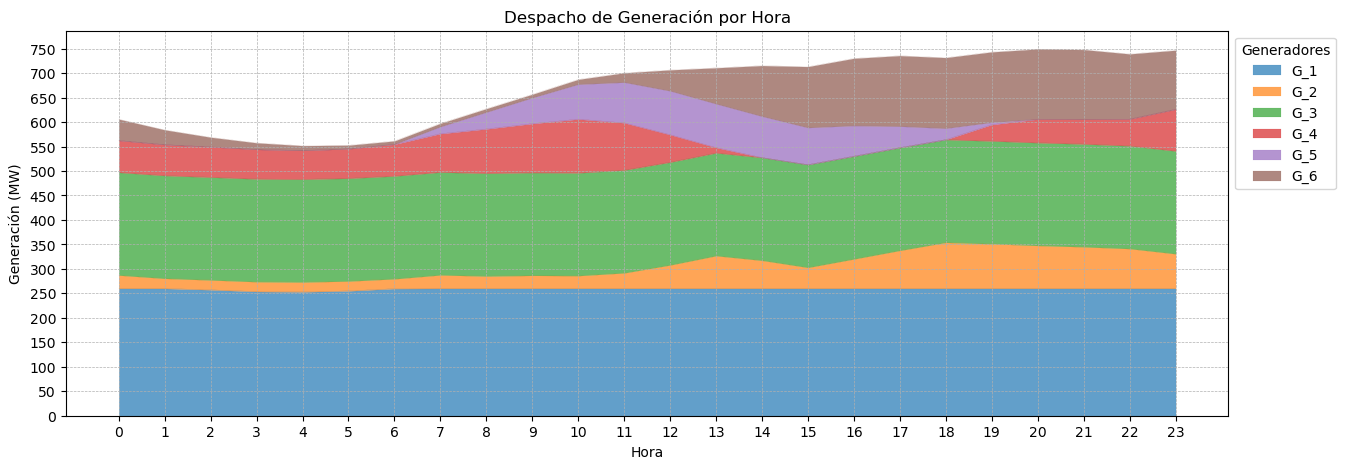

In [31]:
# Visualizaciones típicas de sistemas de potencia:
# 1. Gráfico de áreas para ver las generaciones despachadas por cada generador
fig, ax = plt.subplots(figsize=(15, 5))

# Seleccionar las columnas de generación
df_generacion = df_resultados[[f"G_{g}" for g in m_A.Generadores]]

# Crear el gráfico de áreas dentro del eje definido
df_generacion.plot(kind='area', stacked=True, alpha=0.7, linewidth=0.1, ax=ax)

# Configuración del gráfico
ax.set_xlabel("Hora")
ax.set_ylabel("Generación (MW)")
ax.set_title("Despacho de Generación por Hora")
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(title="Generadores", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0, 24, 1))
ax.set_yticks(range(0, 751, 50))

# Mostrar el gráfico
plt.show()

## Transmisión

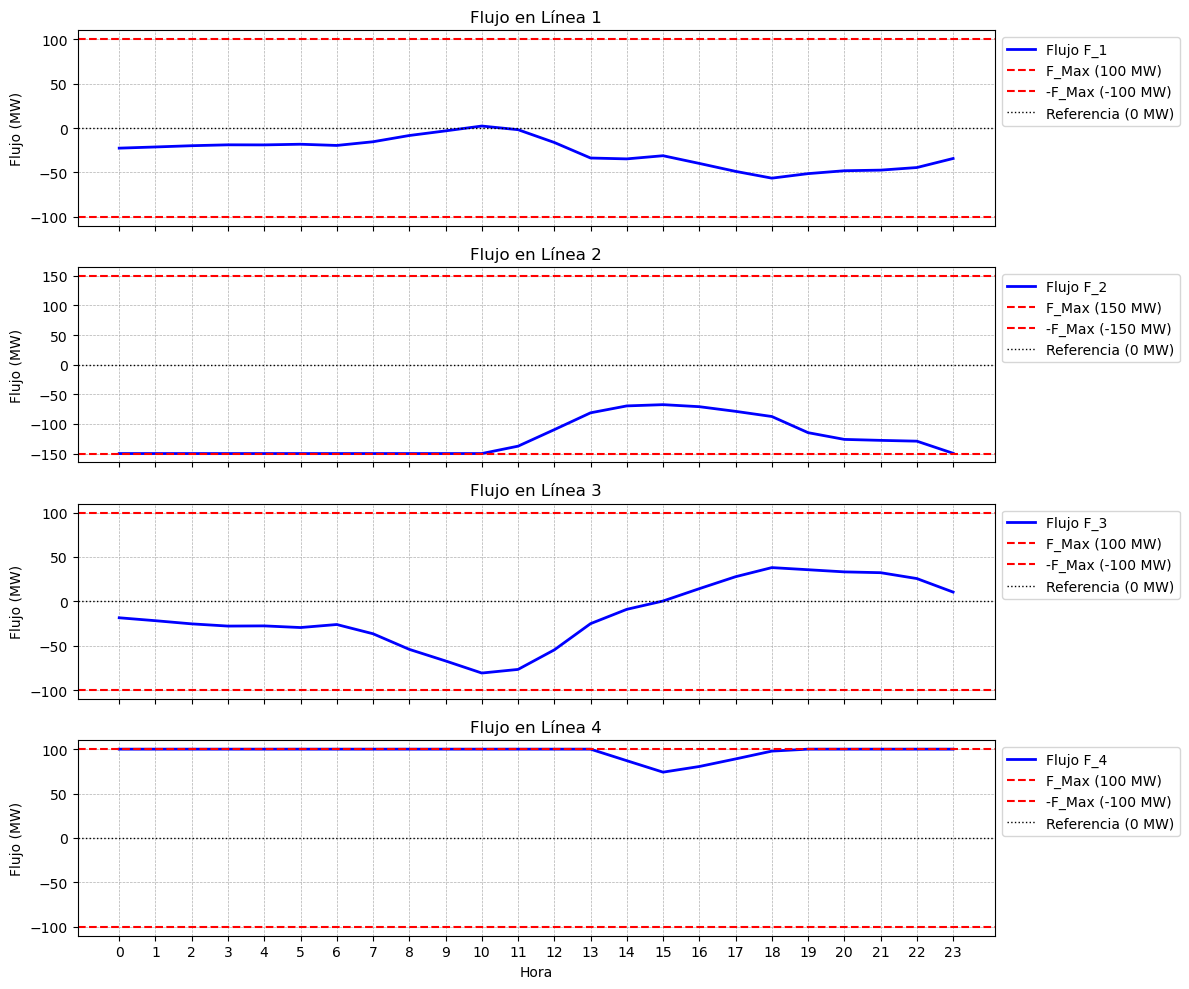

In [32]:
#Flujos por las líneas de transmisión

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

for i, linea in enumerate(m_A.Lineas):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos de flujo para la línea i
    df_flujo = df_resultados[[f"F_{linea}"]]

    # Graficar el flujo
    ax.plot(df_flujo, label=f"Flujo F_{linea}", color='b', linewidth=2)

    # Límites de flujo (F_Max y -F_Max)
    f_max = Lins.loc[Lins["ID"] == linea, "F_Max"].values[0]
    ax.axhline(f_max, color='r', linestyle='--', linewidth=1.5, label=f"F_Max ({f_max} MW)")
    ax.axhline(-f_max, color='r', linestyle='--', linewidth=1.5, label=f"-F_Max ({-f_max} MW)")

    # Línea punteada en y = 0
    ax.axhline(0, color='k', linestyle=':', linewidth=1, label="Referencia (0 MW)")

    # Configurar título y leyenda
    ax.set_title(f"Flujo en Línea {linea}")
    ax.set_ylabel("Flujo (MW)")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Demanda No Suministrada

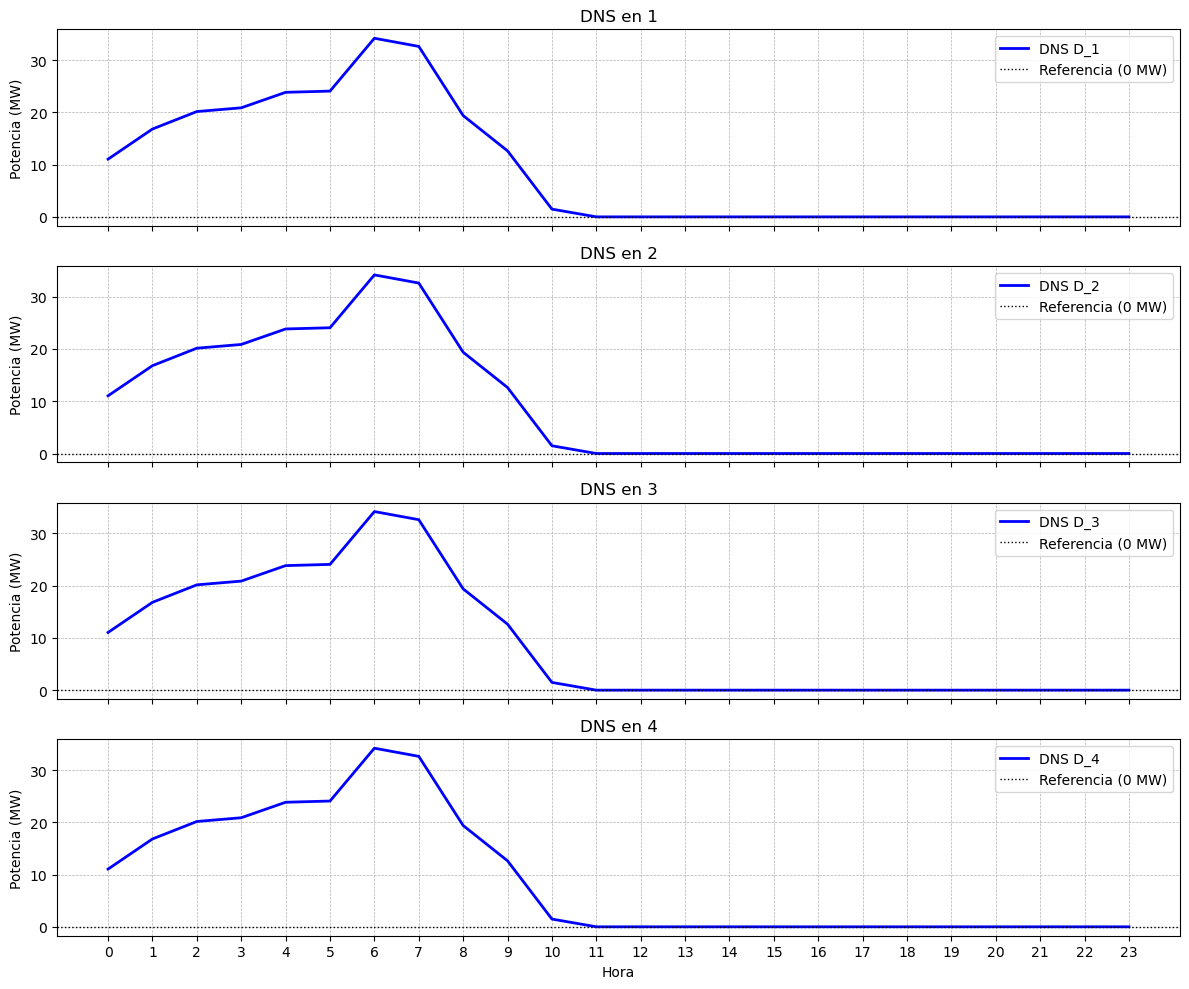

In [33]:
# Demanda no suministrada

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

for i, barra in enumerate(m_A.Barras):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos barra i
    df_dns = df_resultados[[f"D_{d}"]]

    # Graficar
    ax.plot(df_dns, label=f"DNS D_{barra}", color='b', linewidth=2)



    # Línea punteada en y = 0
    ax.axhline(0, color='k', linestyle=':', linewidth=1, label="Referencia (0 MW)")

    # Configurar título y leyenda
    ax.set_title(f"DNS en {barra}")
    ax.set_ylabel("Potencia (MW)")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Binarias on off

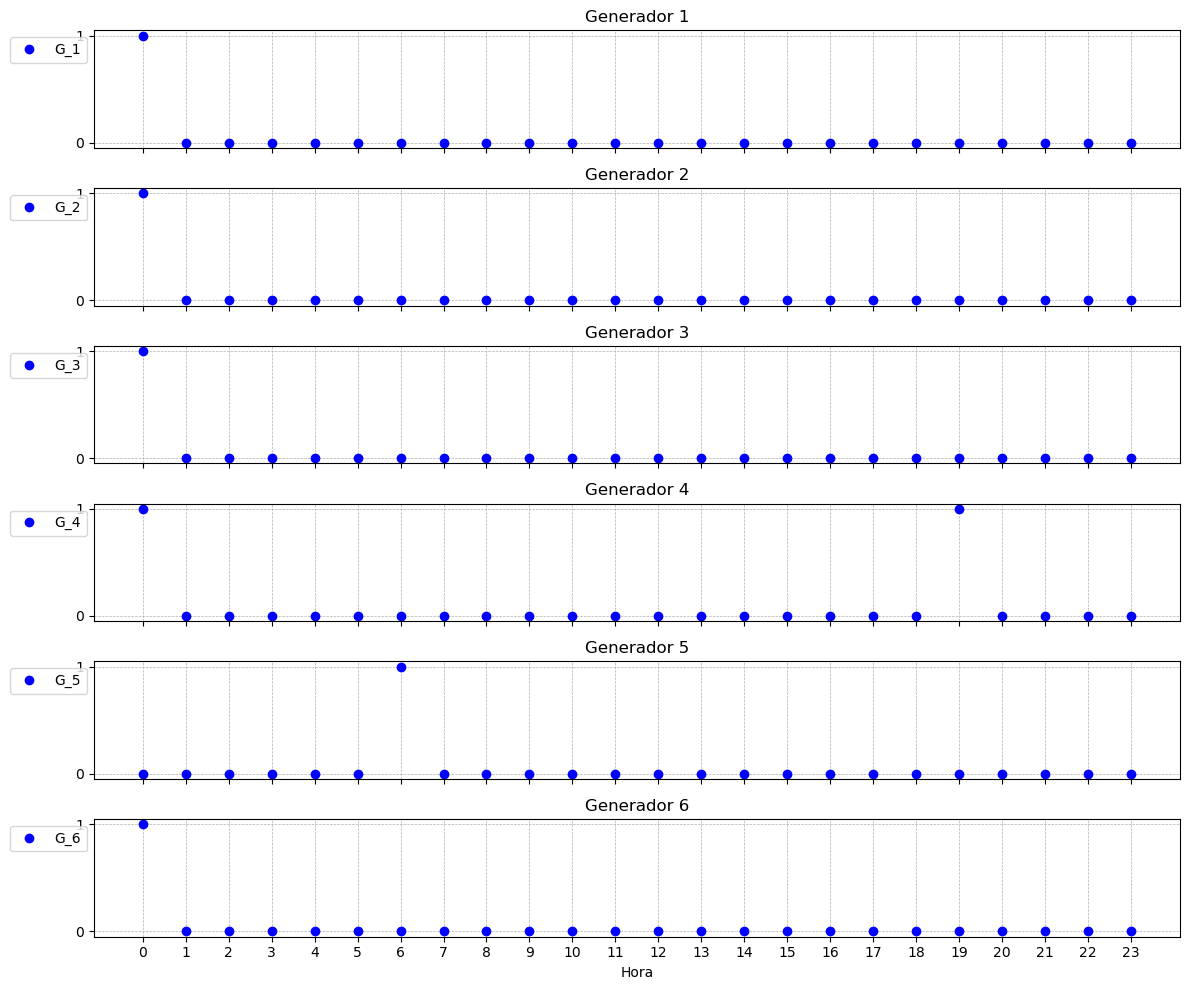

In [34]:
#Variable binaria x_ON

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_A.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_ON = df_resultados[[f"X_ON_{generador}"]]

    # Graficar el flujo
    ax.plot(df_X_ON, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])


# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

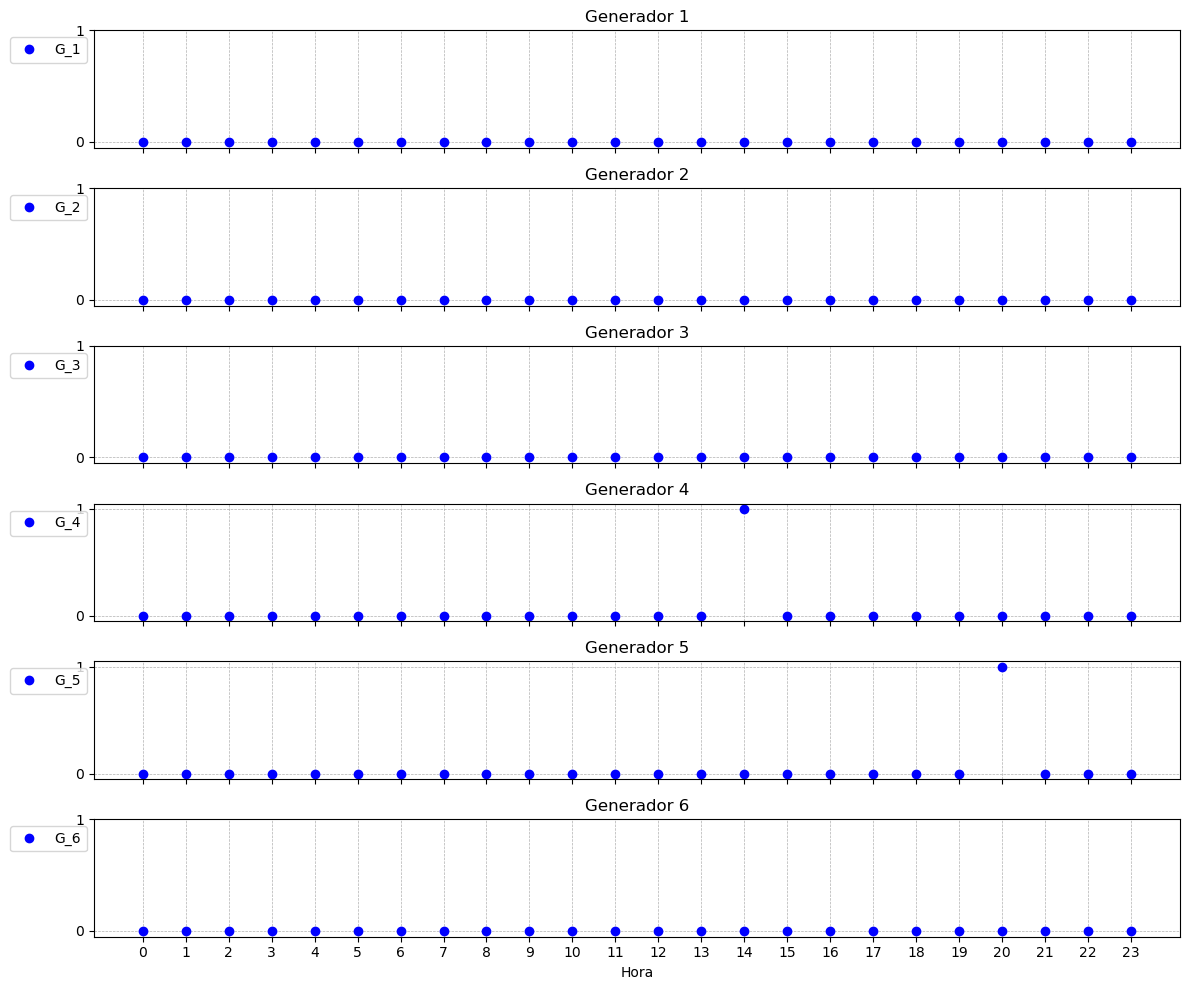

In [35]:
#Variable binaria x_OFF

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_A.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_OFF = df_resultados[[f"X_OFF_{generador}"]]

    # Graficar
    ax.plot(df_X_OFF, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])


# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Binaria de estado

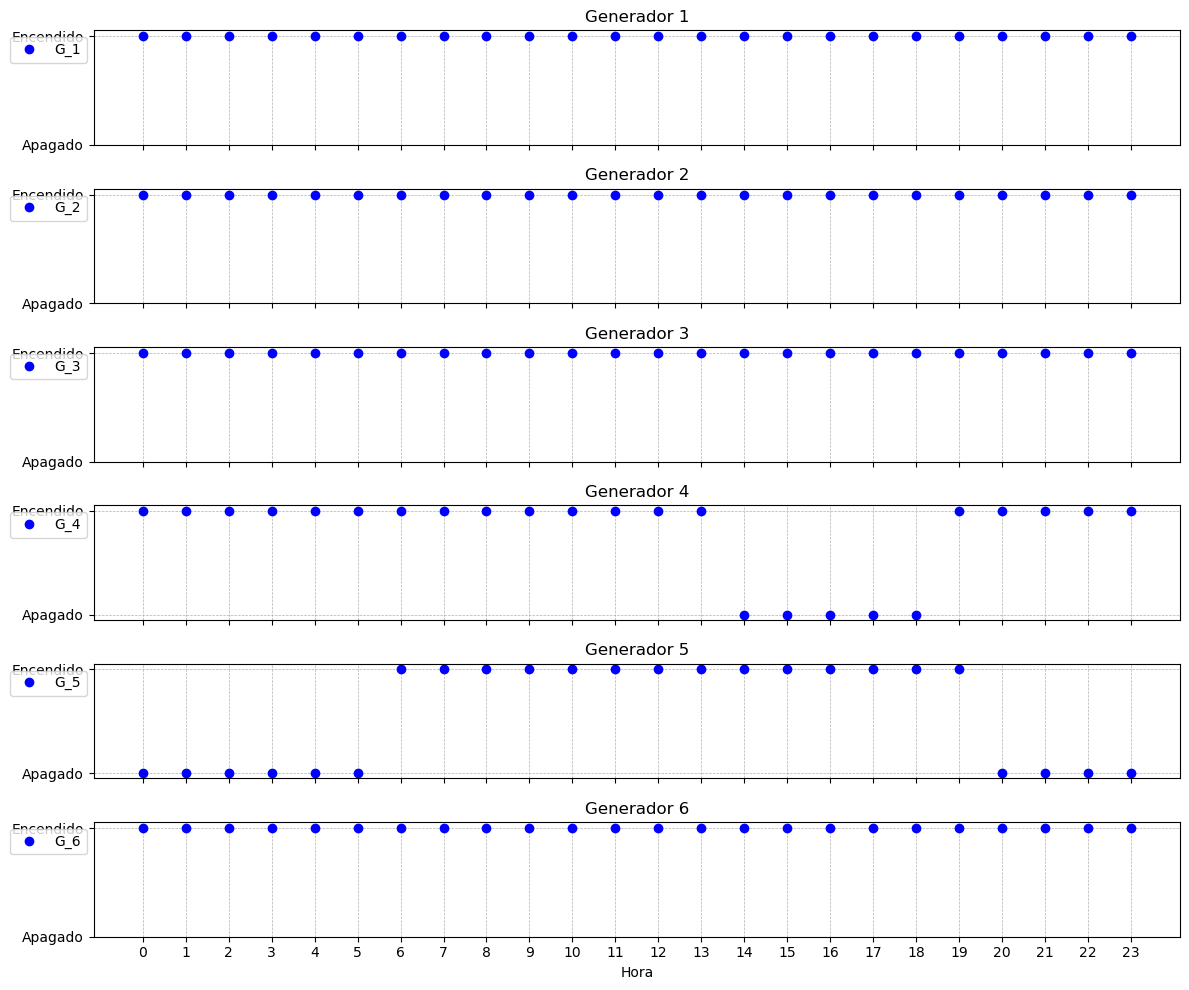

In [36]:
#Variable binaria x_ON

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_A.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_E = df_resultados[[f"X_E_{generador}"]]

    # Graficar el flujo
    ax.plot(df_X_E, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Apagado", "Encendido"])

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Respuestas a preguntas

 se observa al graficar, que sí hay demanda no suminstrada. En particular, entre las horas 0 y 11. Además, no se observan diferencias entre el gráfico de demanda total y el de áreas apiladas obtenido en la Parte B.

In [37]:
#A continuación se muestra el valor optimo de la función objetivo para la parte B
print(m_A.obj())

1031858.6804783884


# Parte C

Formule el problema de despacho económico **considerando todos los costos**, pero siga sin considerar la restricción de rampa.

## Indices

*   $b$: Barras del sistema
*   $g$: Generadores
*   $l$: Lineas de transmisión
*   $t$: Periodos de tiempo

## Parámetros

* $D_{bt}$: Demanda en la barra b en el tiempo t
* $\bar{P}_g$: Capacidad del generador g
* $\pi_g$: Costo variable del generador g
* $\underline{P}_g$: Potencia mínima que puede entregar el generador g
* $Voll$: Valor de demanda perdida
* $\bar{F}_l$: Flujo máximo soportado por la linea l
* $X_l$: Reactancia de la linea l
* $Disp_{gt}$: Potencia máxima relativa disponible del generador g en el tiempo
* $C_g^{E}$: Costo del generador g en encenderse
* $C_g^{A}$: Costo del generador g en apagarse

## Variables

* $f_{lt}$: Flujo por la línea $l$ en el periodo $t$  
* $P_{gt}$: Potencia despachada por el generador $g$ en el periodo $t$  
* $\theta_{lt}^{From}$: Ángulo de voltaje de la barra $From$ de la línea $l$ en
  el periodo $t$  
* $\theta_{lt}^{To}$: Ángulo de voltaje de la barra $To$ de la línea $l$ en el
  periodo $t$
* $D_{bt}^{NS}$: Desconección de carga/demanda
* $X^\text{ON}_{g,t}$: Toma el valor 1 si el generador  g  se enciende en el instante  t  y toma el valor 0 en caso contrario
* $X^\text{OFF}_{g,t}$: Toma el valor 1 si el generador  g  se apaga en el instante  t  y toma el valor 0 en caso contrario
* $X^\text{E}_{g,t}$: Es igual a 1 si el generador  g  está encendido en la hora  t  y 0 cuando esté apagado

## Problema de Optimización

Identico al anterior, salvo los siguientes cambios en la función objetivo, en la cual se añaden los costos fijos de encendido y apagado de cada generador:


$$ \min \sum_{t\in T} \sum_{g\in G} (P_{gt} \pi_g + X^\text{ON}_{g,t}C_g^{E} + X^\text{OFF}_{g,t}C_g^{A}) + \sum_{t\in T} \sum_{b\in B} D_{bt}^{NS}Voll $$
$$s.a:  \sum_{g \in G_b} P_{gt} + \sum_{l \in From_n} f_{lt} = D_{bt} - D_{bt}^{NS} + \sum_{l \in To_n} f_{tl}, \qquad \forall b \in B, \forall t \in T $$
$$ \underline{P}_g X^{E}_{gt} \leq P_{gt} \leq \bar{P}_g Disp_{gt}, \qquad \forall g \in G, \forall t \in T $$
$$ -\bar{F}_l \leq f_{lt} \leq \bar{F}_l, \qquad \forall l \in L, \forall t \in T$$
$$ f_{lt} = \dfrac{\theta^{From}_{lt}-\theta^{To}_{lt}}{X_{l}}, \qquad \forall l \in L, \forall t \in T $$
$$P_{gt} \leq X^{E}_{gt}\bar{P}_g, \qquad \forall g \in G, \forall t \in T $$
$$X^{E}_{g,t} - X^{E}_{g,t-1} = X^\text{ON}_{g,t} - X^\text{OFF}_{g,t} , \qquad \forall g \in G, \forall t \in T$$
$$X^\text{ON}_{g,t} + X^\text{OFF}_{g,t} \leq 1, \qquad \forall g \in G, \forall t \in T$$

# Parte D

Resuelva el problema formulado en la **Parte C** usando Pyomo, comentando cada uno de sus conjuntos, parámetros, variables, función objetivo y restricciones.
* Realice el mismo análisis solicitado en la Parte B
* Explique la diferencia entre las decisiones de encender o apagar centrales obtenidas en las Partes B y D, si es que la hubiera.
* Explique la diferencia de los costos de la función objetivo obtenidos en las Partes B y D, si es que la hubiera.

## Creación del modelo

In [38]:
# Creación del modelo
m_D = ConcreteModel()

##Conjuntos

In [39]:
m_D.Barras      = Set(initialize=range(1,5))
m_D.Generadores = Set(initialize=Gens.ID.tolist())
m_D.Lineas      = Set(initialize=Lins.ID.tolist())
m_D.Horas       = Set(initialize=range(24))

## Parámetros

In [40]:
# Creación de diccionarios para acceder más fácilmente a los parámetros del problema
m_D.Pmax       = Param(m_D.Generadores, initialize=Gens.set_index("ID")["P_Max"].to_dict())
m_D.CV         = Param(m_D.Generadores, initialize=Gens.set_index("ID")["CV"].to_dict())
m_D.BarraGen   = Param(m_D.Generadores, initialize=Gens.set_index("ID")["Barra"].to_dict())
m_D.Fmax       = Param(m_D.Lineas, initialize=Lins.set_index("ID")["F_Max"].to_dict())
m_D.Reactancia = Param(m_D.Lineas, initialize=Lins.set_index("ID")["Reactancia"].to_dict())
m_D.From       = Param(m_D.Lineas, initialize=Lins.set_index("ID")["From"].to_dict())
m_D.To         = Param(m_D.Lineas, initialize=Lins.set_index("ID")["To"].to_dict())
m_D.Pmin       = Param(m_D.Generadores, initialize=Gens.set_index("ID")["P_Min"].to_dict())
m_D.Voll       = 1000

demanda_dict = {(b, h): Dems.loc[h, b] for h in range(24) for b in [1, 2, 3, 4]}
m_D.Demanda = Param(m_D.Barras, m_D.Horas, initialize=demanda_dict)

#Creamos una matriz de 6 x 24 para las potencias maximas disponibles entregadas por cada generador
Matrix_1 = np.ones(24, dtype=int)
PerSol = PerS.iloc[:, 0].values
PerEol = PerE.iloc[:, 0].values
Matrix_2 = [Matrix_1, Matrix_1, Matrix_1, Matrix_1, PerSol, PerEol]
disp = pd.DataFrame(Matrix_2, index=range(1,7))
#Ahora hagamos el dccionario para el modelo
disp_dict = {(g, h): disp.loc[g, h] for h in range(24) for g in [1, 2, 3, 4, 5, 6]}
m_D.Disponibilidad = Param(m_D.Generadores, m_D.Horas, initialize=disp_dict)

#Costos fijos de los generadores al encenderse y apagarse
m_D.C_E = Param(m_D.Generadores, initialize=Gens.set_index("ID")["C_on"].to_dict())
m_D.C_A = Param(m_D.Generadores, initialize=Gens.set_index("ID")["C_off"].to_dict())

## Variables

In [41]:
# Variables
m_D.Pgen   = Var(m_D.Generadores, m_D.Horas, within=NonNegativeReals)
m_D.Flujo  = Var(m_D.Lineas, m_D.Horas, within=Reals)
m_D.Angulo = Var(m_D.Barras, m_D.Horas, within=Reals, bounds=(-3.14, 3.14))
m_D.Dns    = Var(m_D.Barras, m_D.Horas, within=NonNegativeReals)
m_D.X_ON   = Var(m_D.Generadores, m_D.Horas, within=Binary)
m_D.X_OFF  = Var(m_D.Generadores, m_D.Horas, within=Binary)
m_D.X_E    = Var(m_D.Generadores, m_D.Horas, within=Binary)


## Función objetivo

In [42]:
# Función objetivo: Minimizar costos de operación
m_D.obj =Objective(expr=sum(m_D.Pgen[g, t] * m_D.CV[g] + m_D.X_ON[g, t] * m_D.C_E[g] + m_D.X_OFF[g, t] * m_D.C_A[g]  for g in m_D.Generadores for t in m_D.Horas) + sum(m_D.Dns[b, t] * m_D.Voll for b in m_D.Barras for t in m_D.Horas), sense=minimize)

### Prueba Función Objetivo

In [43]:
print(m_D.obj.expr)

50*Pgen[1,0] + 44955*X_ON[1,0] + 22478*X_OFF[1,0] + 50*Pgen[1,1] + 44955*X_ON[1,1] + 22478*X_OFF[1,1] + 50*Pgen[1,2] + 44955*X_ON[1,2] + 22478*X_OFF[1,2] + 50*Pgen[1,3] + 44955*X_ON[1,3] + 22478*X_OFF[1,3] + 50*Pgen[1,4] + 44955*X_ON[1,4] + 22478*X_OFF[1,4] + 50*Pgen[1,5] + 44955*X_ON[1,5] + 22478*X_OFF[1,5] + 50*Pgen[1,6] + 44955*X_ON[1,6] + 22478*X_OFF[1,6] + 50*Pgen[1,7] + 44955*X_ON[1,7] + 22478*X_OFF[1,7] + 50*Pgen[1,8] + 44955*X_ON[1,8] + 22478*X_OFF[1,8] + 50*Pgen[1,9] + 44955*X_ON[1,9] + 22478*X_OFF[1,9] + 50*Pgen[1,10] + 44955*X_ON[1,10] + 22478*X_OFF[1,10] + 50*Pgen[1,11] + 44955*X_ON[1,11] + 22478*X_OFF[1,11] + 50*Pgen[1,12] + 44955*X_ON[1,12] + 22478*X_OFF[1,12] + 50*Pgen[1,13] + 44955*X_ON[1,13] + 22478*X_OFF[1,13] + 50*Pgen[1,14] + 44955*X_ON[1,14] + 22478*X_OFF[1,14] + 50*Pgen[1,15] + 44955*X_ON[1,15] + 22478*X_OFF[1,15] + 50*Pgen[1,16] + 44955*X_ON[1,16] + 22478*X_OFF[1,16] + 50*Pgen[1,17] + 44955*X_ON[1,17] + 22478*X_OFF[1,17] + 50*Pgen[1,18] + 44955*X_ON[1,18] + 22478

## Restricciones

In [44]:
#Restricción de balance de potencia
def balance_rule(m_D, b, t):
    return (sum(m_D.Pgen[g, t] for g in m_D.Generadores if m_D.BarraGen[g] == b)
          - sum(m_D.Flujo[l, t] for l in m_D.Lineas if m_D.To[l] == b)
          + sum(m_D.Flujo[l, t] for l in m_D.Lineas if m_D.From[l] == b)
          + m_D.Dns[b, t]
          == m_D.Demanda[b, t])

m_D.Balance = Constraint(m_D.Barras, m_D.Horas, rule=balance_rule)

#Restricciones de generación
def gen_max_rule(m_D, g, t):
    return m_D.Pgen[g, t] <= m_D.Pmax[g] * m_D.Disponibilidad[g, t]
m_D.GenMax = Constraint(m_D.Generadores, m_D.Horas, rule=gen_max_rule)

def gen_min_rule(m_D, g, t):
    return m_D.Pgen[g, t] >= m_D.Pmin[g] * m_D.X_E[g, t]
m_D.GenMin = Constraint(m_D.Generadores, m_D.Horas, rule=gen_min_rule)

# Restricciones de flujo en líneas
def flujo_max_rule(m_D, l, t):
    return m_D.Flujo[l, t] <= m_D.Fmax[l]
m_D.FlujoMax = Constraint(m_D.Lineas, m_D.Horas, rule=flujo_max_rule)

def flujo_min_rule(m_D, l, t):
    return m_D.Flujo[l, t] >= -m_D.Fmax[l]
m_D.FlujoMin = Constraint(m_D.Lineas, m_D.Horas, rule=flujo_min_rule)

# Restricción de flujo en función de los ángulos
def flujo_rule(m_D, l, t):
    return m_D.Flujo[l, t] * m_D.Reactancia[l] == m_D.Angulo[m_D.From[l], t] - m_D.Angulo[m_D.To[l], t]
m_D.FlujoEq = Constraint(m_D.Lineas, m_D.Horas, rule=flujo_rule)

#Restricción generador no produce si está apagado
def gen_on_off_rule(m_D, g, t):
    return m_D.Pgen[g, t] <= m_D.Pmax[g] * m_D.X_E[g, t]
m_D.GenOnOff = Constraint(m_D.Generadores, m_D.Horas, rule=gen_on_off_rule)

#Restricciones de conmutación de generadores
def conmutacion_rule1(m_D, g, t):
    if t > 0:
        return m_D.X_E[g, t] - m_D.X_E[g, t-1] == m_D.X_ON[g, t] - m_D.X_OFF[g, t]
    else:
        return m_D.X_E[g, t] == m_D.X_ON[g, t] - m_D.X_OFF[g, t]
m_D.Conmutacion1 = Constraint(m_D.Generadores, m_D.Horas, rule=conmutacion_rule1)

def conmutacion_rule2(m_D, g, t):
    return m_D.X_ON[g, t] + m_D.X_OFF[g, t] <= 1

m_D.Conmutacion2 = Constraint(m_D.Generadores, m_D.Horas, rule=conmutacion_rule2)

## Optimización

In [45]:
#Resolver
solver = SolverFactory('glpk')
solver.solve(m_D, tee=True)
print(f"Valor óptimo de la función objetivo = {m_D.obj()} ")

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\eduar\AppData\Local\Temp\tmprm6ntcsx.glpk.raw --wglp C:\Users\eduar\AppData\Local\Temp\tmpwr9mznjx.glpk.glp
 --cpxlp C:\Users\eduar\AppData\Local\Temp\tmppr897hm2.pyomo.lp
Reading problem data from 'C:\Users\eduar\AppData\Local\Temp\tmppr897hm2.pyomo.lp'...
C:\Users\eduar\AppData\Local\Temp\tmppr897hm2.pyomo.lp:7012: warning: lower bound of variable 'x98' redefined
C:\Users\eduar\AppData\Local\Temp\tmppr897hm2.pyomo.lp:7012: warning: upper bound of variable 'x98' redefined
1104 rows, 864 columns, 2442 non-zeros
432 integer variables, all of which are binary
7444 lines were read
Writing problem data to 'C:\Users\eduar\AppData\Local\Temp\tmpwr9mznjx.glpk.glp'...
6093 lines were written
GLPK Integer Optimizer 5.0
1104 rows, 864 columns, 2442 non-zeros
432 integer variables, all of which are binary
Preprocessing...
38 constraint coefficient(s) were reduced
710 rows, 758 columns, 1932 non-zeros
432 

## Resultados

In [46]:
# Inicializar diccionario para almacenar los datos
data2 = {f"G_{g}": [] for g in m_D.Generadores}
data2.update({f"F_{l}": [] for l in m_D.Lineas})
data2.update({f"A_{b}": [] for b in m_D.Barras})
data2.update({f"D_{d}": [] for d in m_D.Barras})
data2.update({f"X_ON_{g}": [] for g in m_D.Generadores})
data2.update({f"X_OFF_{g}": [] for g in m_D.Generadores})
data2.update({f"X_E_{g}": [] for g in m_D.Generadores})

# Recorrer las horas y guardar los valores de las variables
for t in m_D.Horas:
    for g in m_D.Generadores:
        data2[f"G_{g}"].append(m_D.Pgen[g, t]())
    for l in m_D.Lineas:
        data2[f"F_{l}"].append(m_D.Flujo[l, t]())
    for b in m_D.Barras:
        data2[f"A_{b}"].append(m_D.Angulo[b, t]())
    for d in m_D.Barras:
        data2[f"D_{d}"].append(m_D.Dns[b, t]())
    for g in m_D.Generadores:
        data2[f"X_ON_{g}"].append(m_D.X_ON[g, t]())
    for g in m_D.Generadores:
        data2[f"X_OFF_{g}"].append(m_D.X_OFF[g, t]())
    for g in m_D.Generadores:
        data2[f"X_E_{g}"].append(m_D.X_E[g, t]())

# Convertir a DataFrame
df_resultados2 = pd.DataFrame(data2, index=m_D.Horas)

df_resultados2.head(24)

,G_1,G_2,G_3,G_4,G_5,G_6,F_1,F_2,F_3,F_4,...,X_OFF_3,X_OFF_4,X_OFF_5,X_OFF_6,X_E_1,X_E_2,X_E_3,X_E_4,X_E_5,X_E_6
0,260.000000,27.159802,210.0,65.239545,0.000000,43.426594,-22.606166,-150.000000,-18.484585,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,260.000000,20.632344,210.0,63.240664,0.000000,30.089298,-21.284808,-150.000000,-21.787980,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,257.301423,20.000000,210.0,61.938899,0.000000,19.578227,-19.862128,-150.000000,-25.344680,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,253.737124,20.000000,210.0,60.377651,0.000000,13.314740,-18.867348,-150.000000,-27.831631,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,253.083558,20.000000,210.0,58.855001,0.000000,9.752272,-18.951292,-150.000000,-27.621769,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
5,255.063515,20.000000,210.0,60.162816,0.000000,7.405811,-18.208034,-150.000000,-29.479916,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
6,259.659148,20.000000,210.0,64.796111,0.366990,6.453818,-19.570928,-150.000000,-26.072679,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
7,260.000000,27.616833,210.0,78.583175,14.453626,6.582220,-15.411217,-150.000000,-36.471957,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
8,260.000000,25.300803,210.0,90.573601,34.416783,6.930298,-8.386583,-150.000000,-54.033541,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9,260.000000,26.688487,210.0,100.067380,53.041384,6.832849,-3.177442,-150.000000,-67.056396,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


## Generación

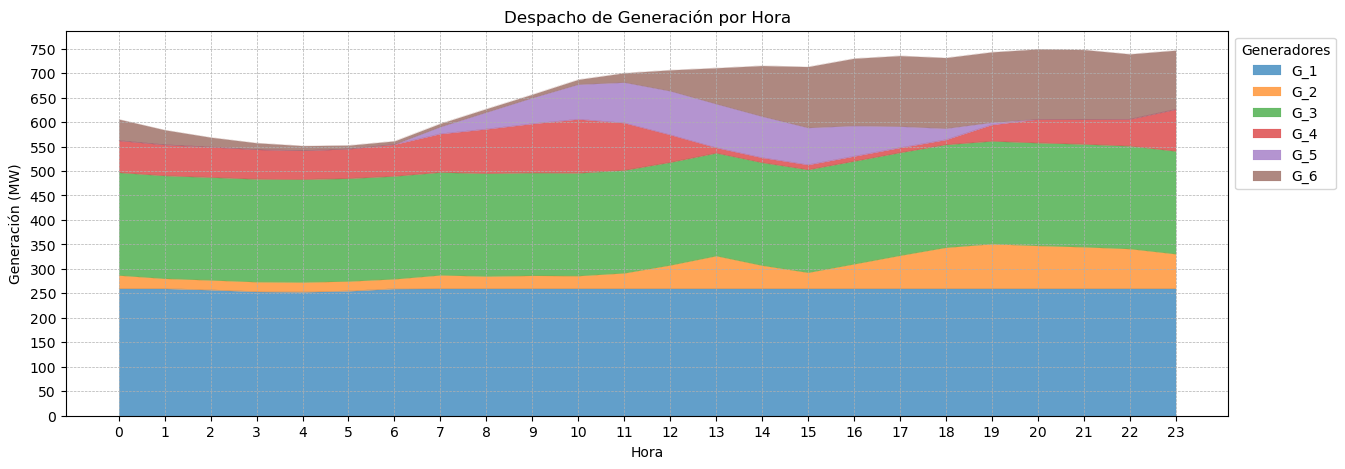

In [47]:
# Visualizaciones típicas de sistemas de potencia:
# 1. Gráfico de áreas para ver las generaciones despachadas por cada generador
fig, ax = plt.subplots(figsize=(15, 5))

# Seleccionar las columnas de generación
df_generacion2 = df_resultados2[[f"G_{g}" for g in m_D.Generadores]]

# Crear el gráfico de áreas dentro del eje definido
df_generacion2.plot(kind='area', stacked=True, alpha=0.7, linewidth=0.1, ax=ax)

# Configuración del gráfico
ax.set_xlabel("Hora")
ax.set_ylabel("Generación (MW)")
ax.set_title("Despacho de Generación por Hora")
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(title="Generadores", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0, 24, 1))
ax.set_yticks(range(0, 751, 50))

# Mostrar el gráfico
plt.show()

## Transmisión

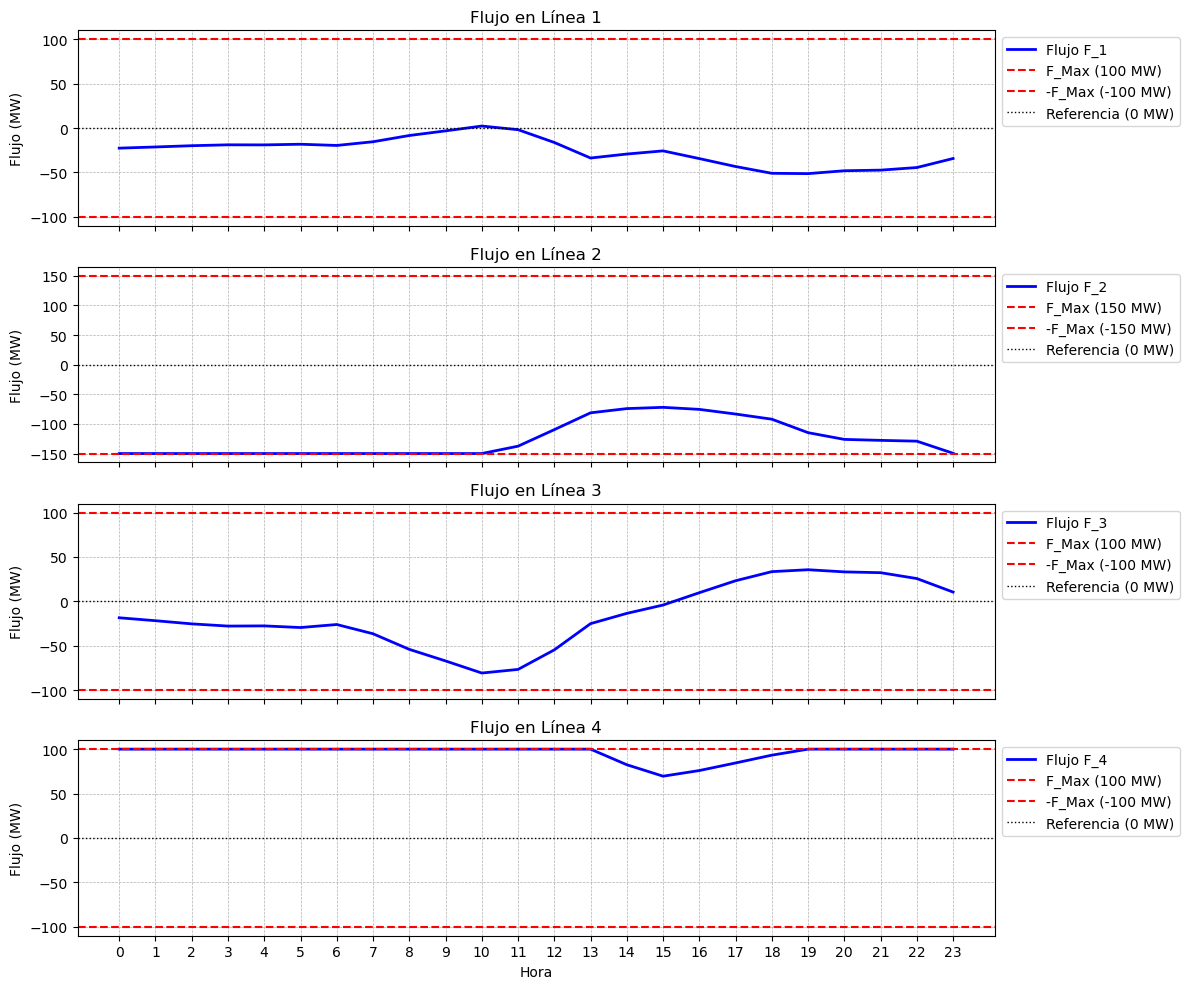

In [48]:
#Flujos por las líneas de transmisión

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

for i, linea in enumerate(m_D.Lineas):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos de flujo para la línea i
    df_flujo = df_resultados2[[f"F_{linea}"]]

    # Graficar el flujo
    ax.plot(df_flujo, label=f"Flujo F_{linea}", color='b', linewidth=2)

    # Límites de flujo (F_Max y -F_Max)
    f_max = Lins.loc[Lins["ID"] == linea, "F_Max"].values[0]
    ax.axhline(f_max, color='r', linestyle='--', linewidth=1.5, label=f"F_Max ({f_max} MW)")
    ax.axhline(-f_max, color='r', linestyle='--', linewidth=1.5, label=f"-F_Max ({-f_max} MW)")

    # Línea punteada en y = 0
    ax.axhline(0, color='k', linestyle=':', linewidth=1, label="Referencia (0 MW)")

    # Configurar título y leyenda
    ax.set_title(f"Flujo en Línea {linea}")
    ax.set_ylabel("Flujo (MW)")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Demanda no suministrada

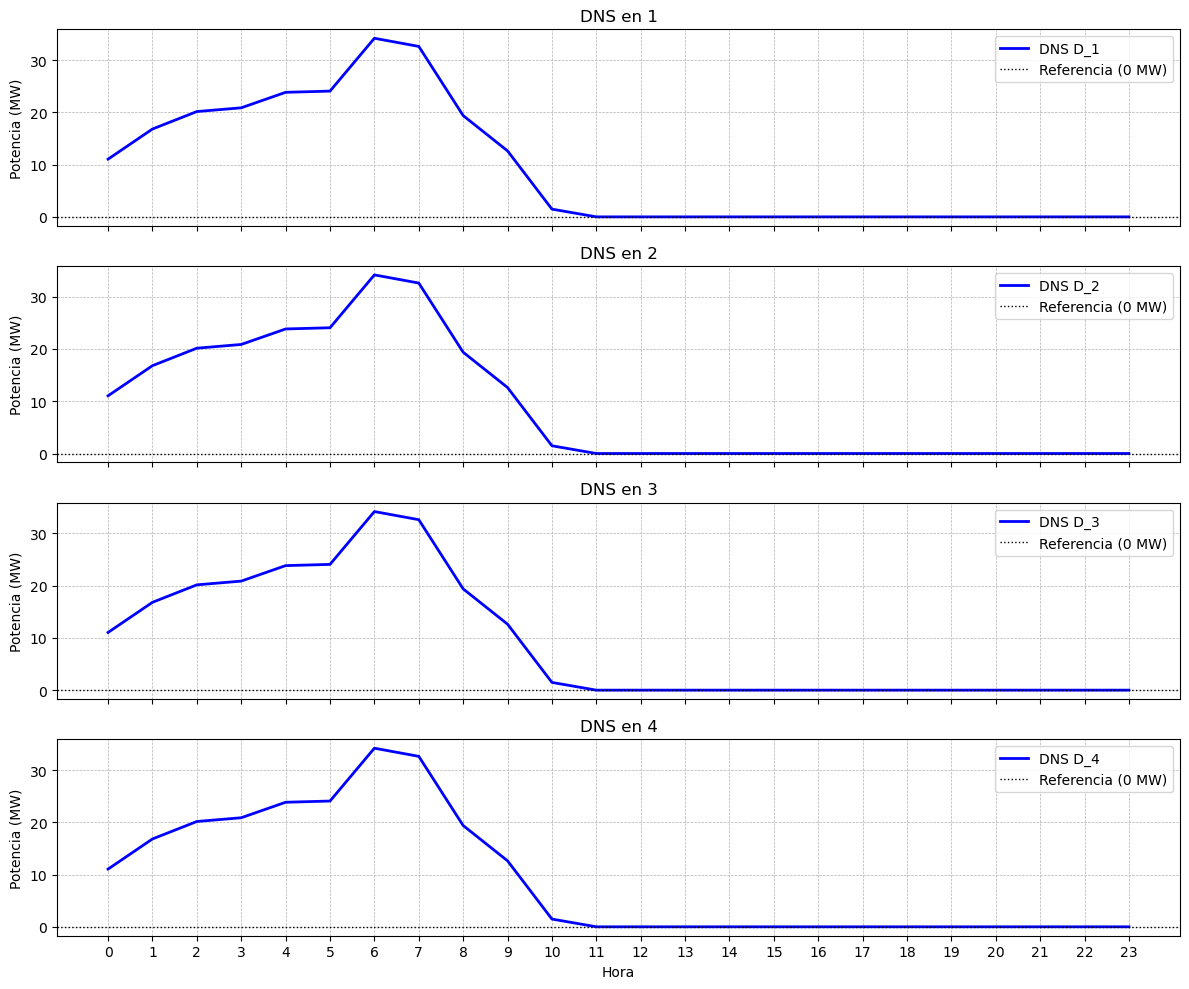

In [49]:
# Demanda no suministrada

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

for i, barra in enumerate(m_D.Barras):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos barra i
    df_dns2 = df_resultados2[[f"D_{d}"]]

    # Graficar
    ax.plot(df_dns2, label=f"DNS D_{barra}", color='b', linewidth=2)



    # Línea punteada en y = 0
    ax.axhline(0, color='k', linestyle=':', linewidth=1, label="Referencia (0 MW)")

    # Configurar título y leyenda
    ax.set_title(f"DNS en {barra}")
    ax.set_ylabel("Potencia (MW)")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Binarias  $X^{ON}$ y $X^{OFF}$

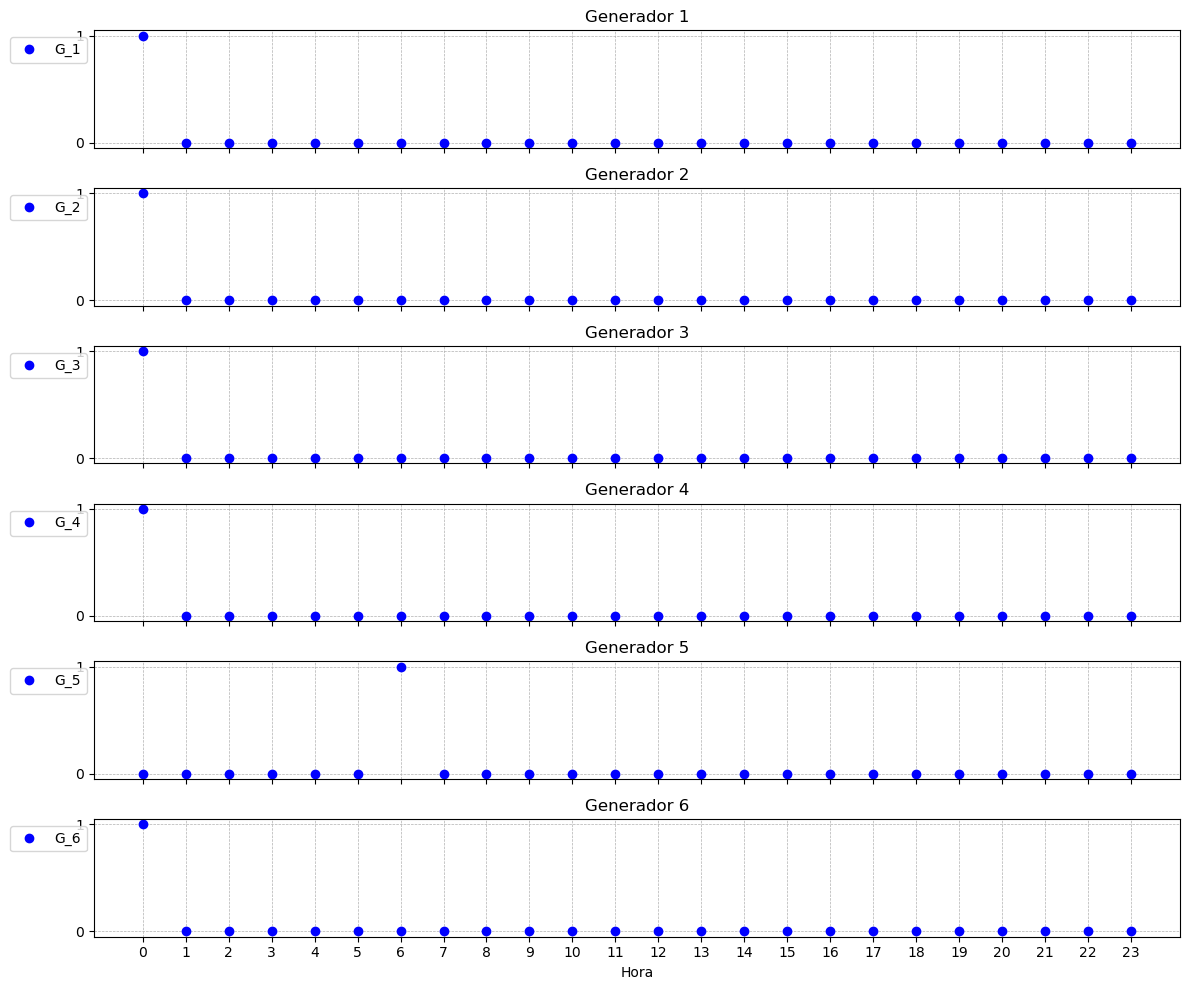

In [50]:
#Variable binaria x_ON

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_D.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_ON = df_resultados2[[f"X_ON_{generador}"]]

    # Graficar el flujo
    ax.plot(df_X_ON, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])


# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

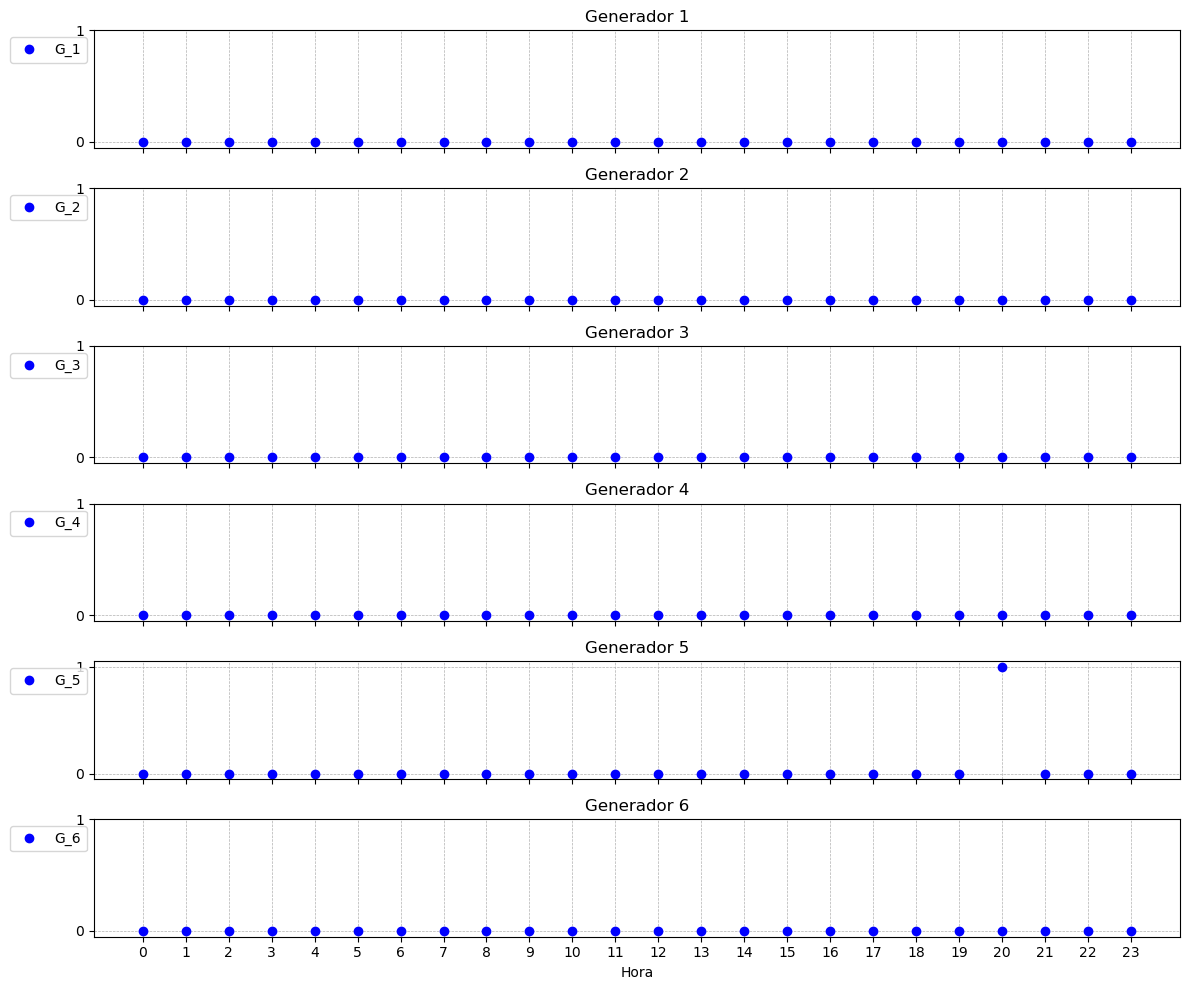

In [51]:
#Variable binaria x_OFF

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_D.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_OFF = df_resultados2[[f"X_OFF_{generador}"]]

    # Graficar
    ax.plot(df_X_OFF, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])


# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Binarias de estado

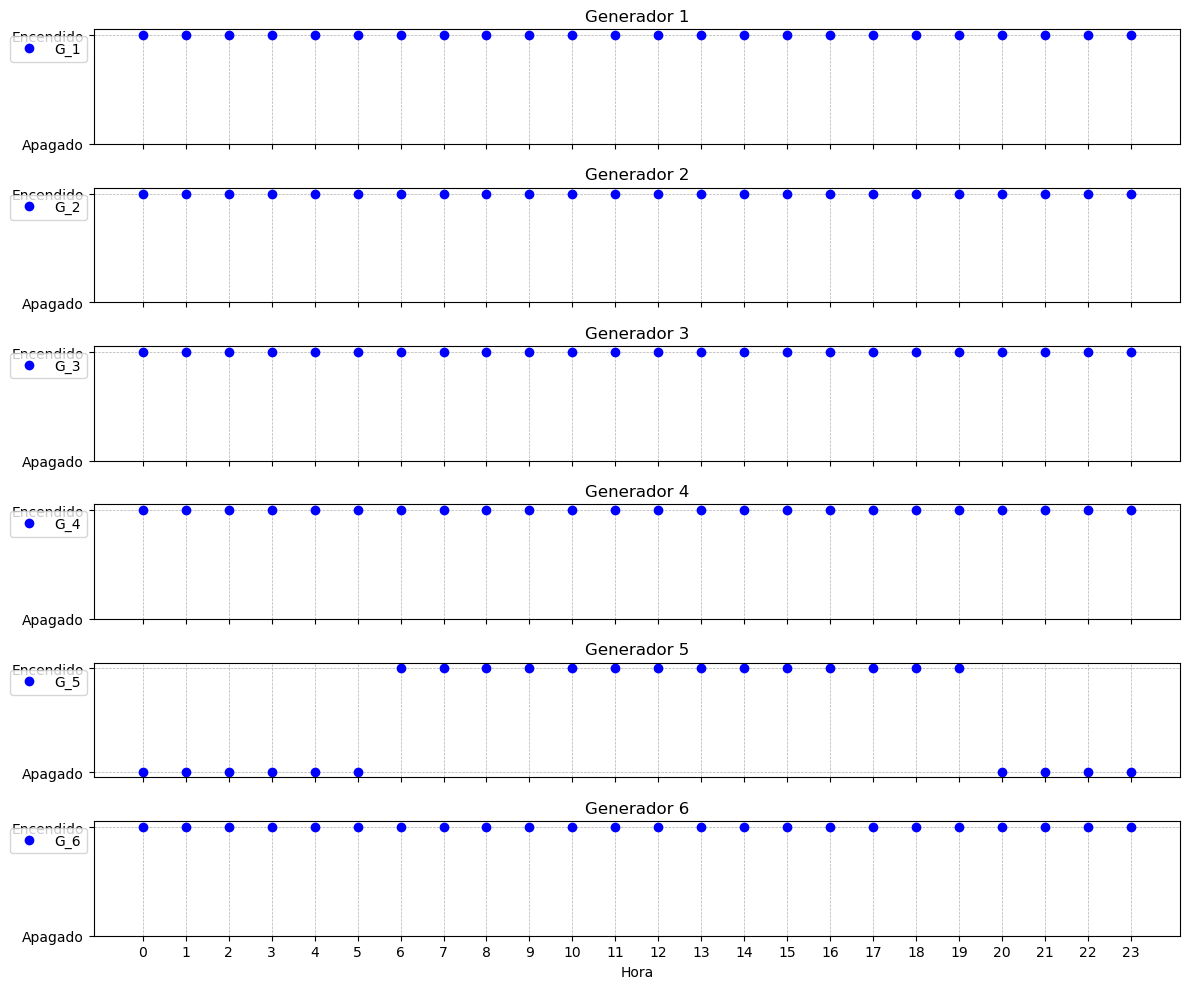

In [52]:
#Variable binaria x_ON

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_D.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_E = df_resultados2[[f"X_E_{generador}"]]

    # Graficar el flujo
    ax.plot(df_X_E, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Apagado", "Encendido"])

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Respuestas a preguntas

No se observan diferencias entre el gráfico de demandas y el gráfico de áreas apiladas obtenido en esta parte.

Por otro lado, se observa al graficar, que sí hay demanda no suminstrada. En particular, entre las horas 0 y 11.

 Por último, se observa que en está parte, a diferencia de la anterior, el generador 4 permanece siempre encendido. Esto se puede explicar de la siguiente manera: Como en la Parte A, no existen costes asociados a encender y apagar el generador, al modelo le conviene apagar $G_{4}$, pues es el que tiene el costo variable más alto. Mientras que en la Parte D, al considerar los costos fijos, al modelo le conviene más que $G_{4}$ funcione a la mínima potencia que es capaz de suminstrar.

 Lo anterior, provoca que el optimo de la función aumente, pues el generador más caro de operar permanece siempre encendido.

In [53]:
#El valor optimo de la función objetivo obtenida para la parte D se muestra a continuación
print(m_D.obj())

1149207.6804783884


# Parte E

Formule el problema de optimización **completo**, usando todos los costos y las restricciones de rampa

## Indices

*   $b$: Barras del sistema
*   $g$: Generadores
*   $l$: Lineas de transmisión
*   $t$: Periodos de tiempo

## Parámetros

* $D_{bt}$: Demanda en la barra b en el tiempo t
* $\bar{P}_g$: Capacidad del generador g
* $\pi_g$: Costo variable del generador g
* $\underline{P}_g$: Potencia mínima que puede entregar el generador g
* $Voll$: Valor de demanda perdida
* $\bar{F}_l$: Flujo máximo soportado por la linea l
* $X_l$: Reactancia de la linea l
* $Disp_{gt}$: Potencia máxima relativa disponible del generador g en el tiempo
* $C_g^{E}$: Costo del generador g en encenderse
* $C_g^{A}$: Costo del generador g en apagarse
* $R_g^{UP}$: Valor rampa de subida del generador g
* $R_g^{DOWN}$: Valor rampa de bajada del generador g

## Variables

* $f_{lt}$: Flujo por la línea $l$ en el periodo $t$  
* $P_{gt}$: Potencia despachada por el generador $g$ en el periodo $t$  
* $\theta_{lt}^{From}$: Ángulo de voltaje de la barra $From$ de la línea $l$ en
  el periodo $t$  
* $\theta_{lt}^{To}$: Ángulo de voltaje de la barra $To$ de la línea $l$ en el
  periodo $t$
* $D_{bt}^{NS}$: Desconección de carga/demanda
* $X^\text{ON}_{g,t}$: Toma el valor 1 si el generador  g  se enciende en el instante  t  y toma el valor 0 en caso contrario
* $X^\text{OFF}_{g,t}$: Toma el valor 1 si el generador  g  se apaga en el instante  t  y toma el valor 0 en caso contrario
* $X^\text{E}_{g,t}$: Es igual a 1 si el generador  g  está encendido en la hora  t  y 0 cuando esté apagado

## Problema de Optmización

Identico al anterior, salvo por las últimas dos restricciones, las cuales corresponden a las rampa de subida cuando el generador incrementa su generación y la de rampa de bajada, cuando el generador disminuye su generación.

$$ \min \sum_{t\in T} \sum_{g\in G} (P_{gt} \pi_g + X^\text{ON}_{g,t}C_g^{E} + X^\text{OFF}_{g,t}C_g^{A}) + \sum_{t\in T} \sum_{b\in B} D_{bt}^{NS}Voll $$
$$s.a:  \sum_{g \in G_b} P_{gt} + \sum_{l \in From_n} f_{lt} = D_{bt} - D_{bt}^{NS} + \sum_{l \in To_n} f_{tl}, \qquad \forall b \in B, \forall t \in T $$
$$ \underline{P}_g X^{E}_{gt} \leq P_{gt} \leq \bar{P}_g Disp_{gt}, \qquad \forall g \in G, \forall t \in T $$
$$ -\bar{F}_l \leq f_{lt} \leq \bar{F}_l, \qquad \forall l \in L, \forall t \in T$$
$$ f_{lt} = \dfrac{\theta^{From}_{lt}-\theta^{To}_{lt}}{X_{l}}, \qquad \forall l \in L, \forall t \in T $$
$$P_{gt} \leq X^{E}_{gt}\bar{P}_g, \qquad \forall g \in G, \forall t \in T $$
$$X^{E}_{g,t} - X^{E}_{g,t-1} = X^\text{ON}_{g,t} - X^\text{OFF}_{g,t} , \qquad \forall g \in G, \forall t \in T$$
$$X^\text{ON}_{g,t} + X^\text{OFF}_{g,t} \leq 1, \qquad \forall g \in G, \forall t \in T$$
$$P_{g,t+1} - P_{g,t} \leq R_g^{UP}X^{E}_{g,t}, \qquad \forall g \in G, \forall t \in T $$
$$P_{g,t} - P_{g,t+1} \leq R_g^{DOWN}X^{E}_{g,t}, \qquad \forall g \in G, \forall t \in T $$

# Parte F

Resuelva el problema formulado en la **Parte E** usando Pyomo, comentando cada uno de sus conjuntos, parámetros, variables, función objetivo y restricciones.
* Realice el mismo análisis gráfico solicitado en las Partes B y D
* ¿Se activa la restricción de rampa para algún generador?
* Explique la diferencia entre los costos de la función objetivo obtenidos en la Parte B, D y F, si es que la hubiera.

## Creación del modelo

In [54]:
# Creación del modelo
m_F = ConcreteModel()

## Conjuntos

In [55]:
m_F.Barras      = Set(initialize=range(1,5))
m_F.Generadores = Set(initialize=Gens.ID.tolist())
m_F.Lineas      = Set(initialize=Lins.ID.tolist())
m_F.Horas       = Set(initialize=range(24))

## Parámetros

In [56]:
# Creación de diccionarios para acceder más fácilmente a los parámetros del problema
m_F.Pmax       = Param(m_F.Generadores, initialize=Gens.set_index("ID")["P_Max"].to_dict())
m_F.CV         = Param(m_F.Generadores, initialize=Gens.set_index("ID")["CV"].to_dict())
m_F.BarraGen   = Param(m_F.Generadores, initialize=Gens.set_index("ID")["Barra"].to_dict())
m_F.Fmax       = Param(m_F.Lineas, initialize=Lins.set_index("ID")["F_Max"].to_dict())
m_F.Reactancia = Param(m_F.Lineas, initialize=Lins.set_index("ID")["Reactancia"].to_dict())
m_F.From       = Param(m_F.Lineas, initialize=Lins.set_index("ID")["From"].to_dict())
m_F.To         = Param(m_F.Lineas, initialize=Lins.set_index("ID")["To"].to_dict())
m_F.Pmin       = Param(m_F.Generadores, initialize=Gens.set_index("ID")["P_Min"].to_dict())
m_F.Voll       = 1000

demanda_dict = {(b, h): Dems.loc[h, b] for h in range(24) for b in [1, 2, 3, 4]}
m_F.Demanda = Param(m_F.Barras, m_F.Horas, initialize=demanda_dict)

#Creamos una matriz de 6 x 24 para las potencias maximas disponibles entregadas por cada generador
Matrix_1 = np.ones(24, dtype=int)
PerSol = PerS.iloc[:, 0].values
PerEol = PerE.iloc[:, 0].values
Matrix_2 = [Matrix_1, Matrix_1, Matrix_1, Matrix_1, PerSol, PerEol]
disp = pd.DataFrame(Matrix_2, index=range(1,7))
#Ahora hagamos el dccionario para el modelo
disp_dict = {(g, h): disp.loc[g, h] for h in range(24) for g in [1, 2, 3, 4, 5, 6]}
m_F.Disponibilidad = Param(m_F.Generadores, m_F.Horas, initialize=disp_dict)

#Costos fijos de los generadores al encenderse y apagarse
m_F.C_E = Param(m_F.Generadores, initialize=Gens.set_index("ID")["C_on"].to_dict())
m_F.C_A = Param(m_F.Generadores, initialize=Gens.set_index("ID")["C_off"].to_dict())

#Valores de rampa de subida y bajada
m_F.R_UP = Param(m_F.Generadores, initialize=Gens.set_index("ID")["R_up"].to_dict())
m_F.R_DOWN = Param(m_F.Generadores, initialize=Gens.set_index("ID")["R_down"].to_dict())

## Variables

In [57]:
# Variables
m_F.Pgen   = Var(m_F.Generadores, m_F.Horas, within=NonNegativeReals)
m_F.Flujo  = Var(m_F.Lineas, m_F.Horas, within=Reals)
m_F.Angulo = Var(m_F.Barras, m_F.Horas, within=Reals, bounds=(-3.14, 3.14))
m_F.Dns    = Var(m_F.Barras, m_F.Horas, within=NonNegativeReals)
m_F.X_ON   = Var(m_F.Generadores, m_F.Horas, within=Binary)
m_F.X_OFF  = Var(m_F.Generadores, m_F.Horas, within=Binary)
m_F.X_E    = Var(m_F.Generadores, m_F.Horas, within=Binary)


## Función objetivo

In [58]:
# Función objetivo: Minimizar costos de operación
m_F.obj =Objective(expr=sum(m_F.Pgen[g, t] * m_F.CV[g] + m_F.X_ON[g, t] * m_F.C_E[g] + m_F.X_OFF[g, t] * m_F.C_A[g]  for g in m_F.Generadores for t in m_F.Horas) + sum(m_F.Dns[b, t] * m_F.Voll for b in m_F.Barras for t in m_F.Horas), sense=minimize)

## Restricciones

In [59]:
#Restricción de balance de potencia
def balance_rule(m_F, b, t):
    return (sum(m_F.Pgen[g, t]  for g in m_F.Generadores if m_F.BarraGen[g] == b)
          - sum(m_F.Flujo[l, t] for l in m_F.Lineas if m_F.To[l] == b)
          + sum(m_F.Flujo[l, t] for l in m_F.Lineas if m_F.From[l] == b)
          + m_F.Dns[b, t]
          == m_F.Demanda[b, t])

m_F.Balance = Constraint(m_F.Barras, m_F.Horas, rule=balance_rule)

#Restricciones de generación
def gen_max_rule(m_F, g, t):
    return m_F.Pgen[g, t] <= m_F.Pmax[g] * m_F.Disponibilidad[g, t] * m_F.X_E[g, t]
m_F.GenMax = Constraint(m_F.Generadores, m_F.Horas, rule=gen_max_rule)

def gen_min_rule(m_F, g, t):
    return m_F.Pgen[g, t] >= m_F.Pmin[g] * m_F.X_E[g, t]
m_F.GenMin = Constraint(m_F.Generadores, m_F.Horas, rule=gen_min_rule)

# Restricciones de flujo en líneas
def flujo_max_rule(m_F, l, t):
    return m_F.Flujo[l, t] <= m_F.Fmax[l]
m_F.FlujoMax = Constraint(m_F.Lineas, m_F.Horas, rule=flujo_max_rule)

def flujo_min_rule(m_F, l, t):
    return m_F.Flujo[l, t] >= -m_F.Fmax[l]
m_F.FlujoMin = Constraint(m_F.Lineas, m_F.Horas, rule=flujo_min_rule)

# Restricción de flujo en función de los ángulos
def flujo_rule(m_F, l, t):
    return m_F.Flujo[l, t] * m_F.Reactancia[l] == m_F.Angulo[m_F.From[l], t] - m_F.Angulo[m_F.To[l], t]
m_F.FlujoEq = Constraint(m_F.Lineas, m_F.Horas, rule=flujo_rule)

#Restricción generador no produce si está apagado
def gen_on_off_rule(m_F, g, t):
    return m_F.Pgen[g, t] <= m_F.Pmax[g] * m_F.X_E[g, t]
m_F.GenOnOff = Constraint(m_F.Generadores, m_F.Horas, rule=gen_on_off_rule)

#Restricciones de conmutación de generadores
def conmutacion_rule1(m_F, g, t):
    if t > 0:
        return m_F.X_E[g, t] - m_F.X_E[g, t-1] == m_F.X_ON[g, t] - m_F.X_OFF[g, t]
    else:
        return m_F.X_E[g, t] == m_F.X_ON[g, t] - m_F.X_OFF[g, t]
m_F.Conmutacion1 = Constraint(m_F.Generadores, m_F.Horas, rule=conmutacion_rule1)

def conmutacion_rule2(m_F, g, t):
    return m_F.X_ON[g, t] + m_F.X_OFF[g, t] <= 1

m_F.Conmutacion2 = Constraint(m_F.Generadores, m_F.Horas, rule=conmutacion_rule2)

#Restricciones de rampa
def rampa_up_rule(m_F, g, t):
    if t < 23:
        return m_F.Pgen[g, t+1] - m_F.Pgen[g, t] <= m_F.R_UP[g] * m_F.X_E[g, t]
    else:
        return Constraint.Skip
m_F.RampaUp = Constraint(m_F.Generadores, m_F.Horas, rule=rampa_up_rule)

def rampa_down_rule(m_F, g, t):
    if t < 23:
        return m_F.Pgen[g, t] - m_F.Pgen[g, t+1] <= m_F.R_DOWN[g] * m_F.X_E[g, t]
    else:
        return Constraint.Skip
m_F.RampaDown = Constraint(m_F.Generadores, m_F.Horas, rule=rampa_down_rule)

## Optimización

In [60]:
#Resolver
solver = SolverFactory('glpk')
solver.solve(m_F, tee=False)
print(f"Valor óptimo de la función objetivo = {m_F.obj()} ")

Valor óptimo de la función objetivo = 1149620.8214310643 


## Resultados

In [61]:
# Inicializar diccionario para almacenar los datos
data3 = {f"G_{g}": [] for g in m_F.Generadores}
data3.update({f"F_{l}": [] for l in m_F.Lineas})
data3.update({f"A_{b}": [] for b in m_F.Barras})
data3.update({f"D_{d}": [] for d in m_F.Barras})
data3.update({f"X_ON_{g}": [] for g in m_F.Generadores})
data3.update({f"X_OFF_{g}": [] for g in m_F.Generadores})
data3.update({f"X_E_{g}": [] for g in m_F.Generadores})

# Recorrer las horas y guardar los valores de las variables
for t in m_F.Horas:
    for g in m_F.Generadores:
        data3[f"G_{g}"].append(m_F.Pgen[g, t]())
    for l in m_F.Lineas:
        data3[f"F_{l}"].append(m_F.Flujo[l, t]())
    for b in m_F.Barras:
        data3[f"A_{b}"].append(m_F.Angulo[b, t]())
    for d in m_F.Barras:
        data3[f"D_{d}"].append(m_F.Dns[b, t]())
    for g in m_F.Generadores:
        data3[f"X_ON_{g}"].append(m_F.X_ON[g, t]())
    for g in m_F.Generadores:
        data3[f"X_OFF_{g}"].append(m_F.X_OFF[g, t]())
    for g in m_F.Generadores:
        data3[f"X_E_{g}"].append(m_F.X_E[g, t]())

# Convertir a DataFrame
df_resultados3 = pd.DataFrame(data3, index=m_F.Horas)

df_resultados3.head(24)

,G_1,G_2,G_3,G_4,G_5,G_6,F_1,F_2,F_3,F_4,...,X_OFF_3,X_OFF_4,X_OFF_5,X_OFF_6,X_E_1,X_E_2,X_E_3,X_E_4,X_E_5,X_E_6
0,260.000000,27.159802,210.0,65.239545,0.000000,43.426594,-22.606166,-150.000000,-18.484585,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,260.000000,20.632344,210.0,63.240664,0.000000,30.089298,-21.284808,-150.000000,-21.787980,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,257.301423,20.000000,210.0,61.938899,0.000000,19.578227,-19.862128,-150.000000,-25.344680,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,253.737124,20.000000,210.0,60.377651,0.000000,13.314740,-18.867348,-150.000000,-27.831631,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,253.083558,20.000000,210.0,58.855001,0.000000,9.752272,-18.951292,-150.000000,-27.621769,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
5,255.063515,20.000000,210.0,60.162816,0.000000,7.405811,-18.208034,-150.000000,-29.479916,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6,259.659148,20.000000,210.0,64.796111,0.366990,6.453818,-19.570928,-150.000000,-26.072679,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
7,260.000000,27.616833,210.0,78.583175,14.453626,6.582220,-15.411217,-150.000000,-36.471957,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
8,260.000000,25.300803,210.0,90.573601,34.416783,6.930298,-8.386583,-150.000000,-54.033541,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
9,260.000000,26.688487,210.0,100.067380,53.041384,6.832849,-3.177442,-150.000000,-67.056396,100.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


## Generación

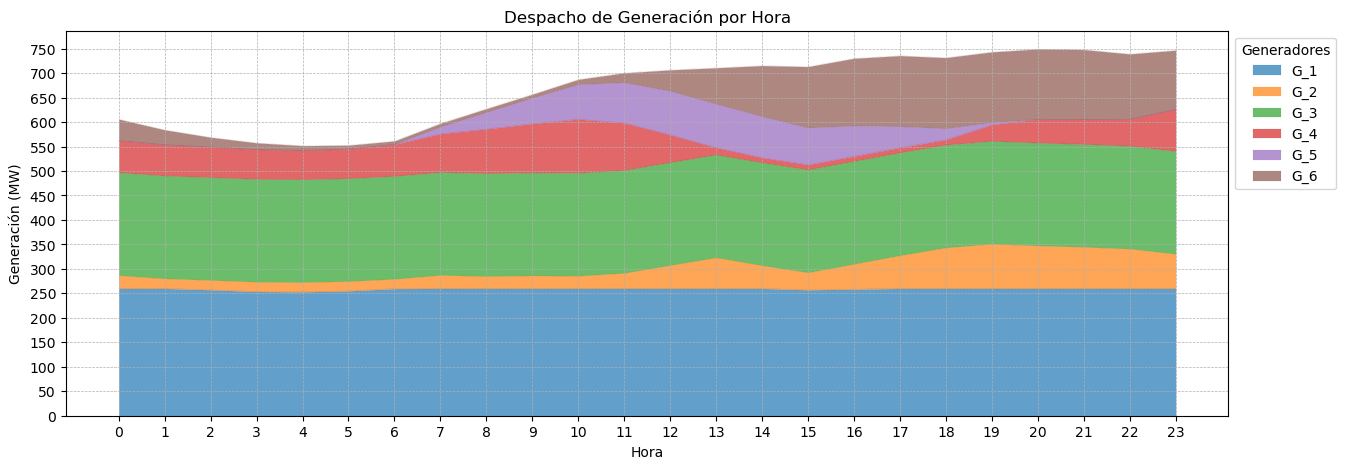

In [62]:
# Visualizaciones típicas de sistemas de potencia:
# 1. Gráfico de áreas para ver las generaciones despachadas por cada generador
fig, ax = plt.subplots(figsize=(15, 5))

# Seleccionar las columnas de generación
df_generacion3 = df_resultados3[[f"G_{g}" for g in m_F.Generadores]]

# Crear el gráfico de áreas dentro del eje definido
df_generacion3.plot(kind='area', stacked=True, alpha=0.7, linewidth=0.1, ax=ax)

# Configuración del gráfico
ax.set_xlabel("Hora")
ax.set_ylabel("Generación (MW)")
ax.set_title("Despacho de Generación por Hora")
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(title="Generadores", bbox_to_anchor=(1, 1))
ax.set_xticks(range(0, 24, 1))
ax.set_yticks(range(0, 751, 50))

# Mostrar el gráfico
plt.show()

## Transmisión

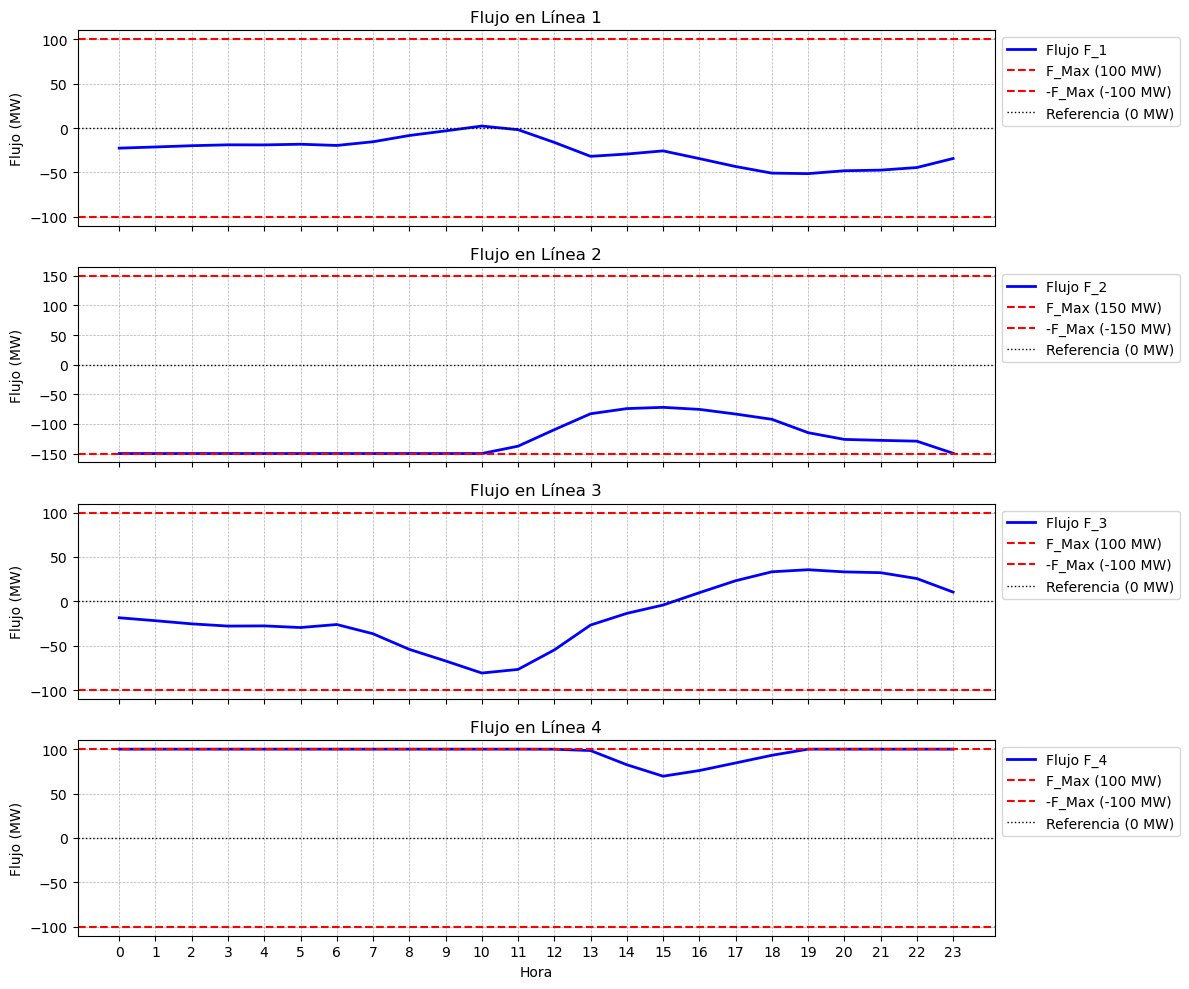

In [63]:
#Flujos por las líneas de transmisión

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

for i, linea in enumerate(m_F.Lineas):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos de flujo para la línea i
    df_flujo3 = df_resultados3[[f"F_{linea}"]]

    # Graficar el flujo
    ax.plot(df_flujo3, label=f"Flujo F_{linea}", color='b', linewidth=2)

    # Límites de flujo (F_Max y -F_Max)
    f_max = Lins.loc[Lins["ID"] == linea, "F_Max"].values[0]
    ax.axhline(f_max, color='r', linestyle='--', linewidth=1.5, label=f"F_Max ({f_max} MW)")
    ax.axhline(-f_max, color='r', linestyle='--', linewidth=1.5, label=f"-F_Max ({-f_max} MW)")

    # Línea punteada en y = 0
    ax.axhline(0, color='k', linestyle=':', linewidth=1, label="Referencia (0 MW)")

    # Configurar título y leyenda
    ax.set_title(f"Flujo en Línea {linea}")
    ax.set_ylabel("Flujo (MW)")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Demanda No Suministrada

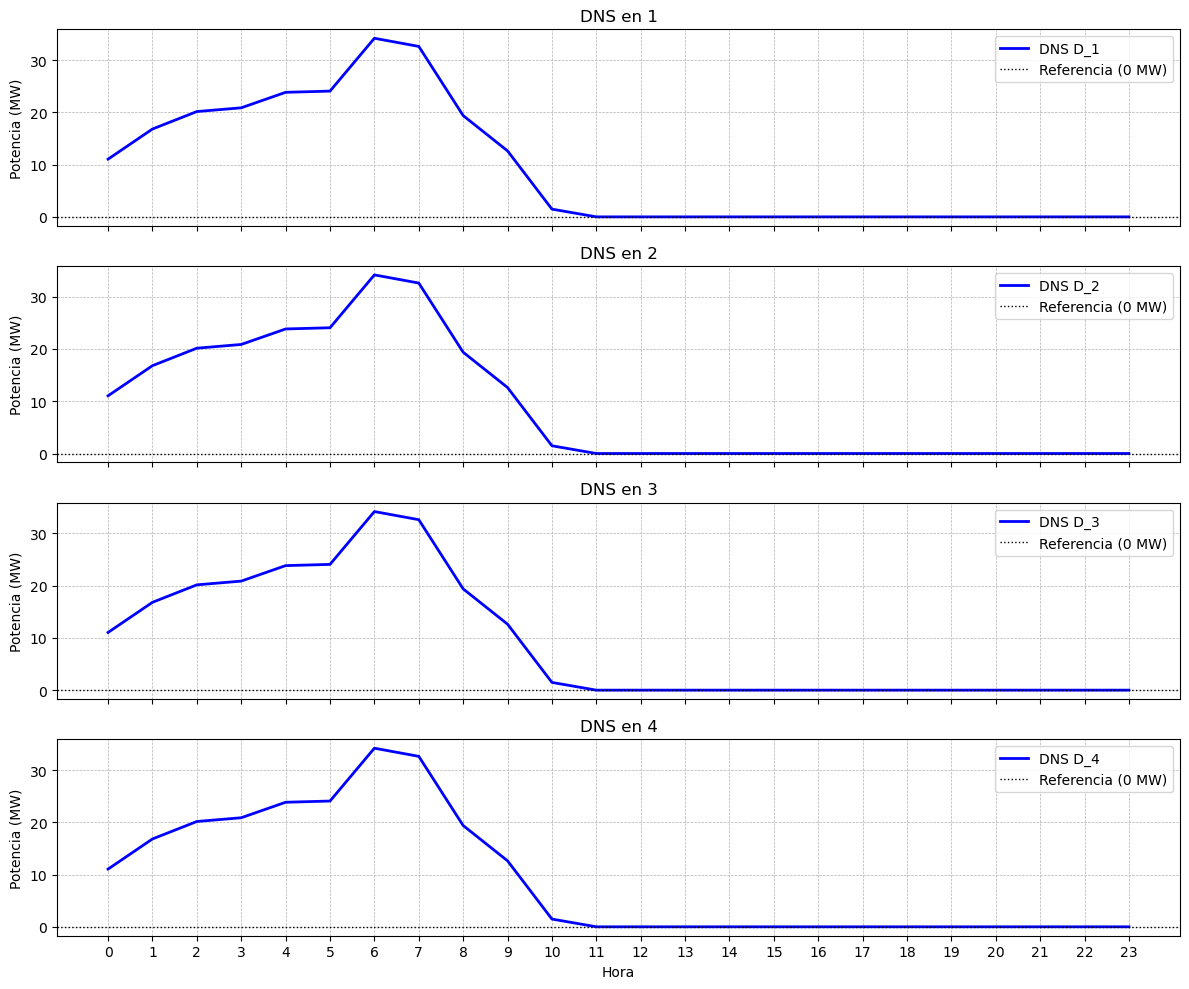

In [64]:
# Demanda no suministrada

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10), sharex=True)

for i, barra in enumerate(m_F.Barras):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos barra i
    df_dns3 = df_resultados3[[f"D_{d}"]]

    # Graficar
    ax.plot(df_dns3, label=f"DNS D_{barra}", color='b', linewidth=2)



    # Línea punteada en y = 0
    ax.axhline(0, color='k', linestyle=':', linewidth=1, label="Referencia (0 MW)")

    # Configurar título y leyenda
    ax.set_title(f"DNS en {barra}")
    ax.set_ylabel("Potencia (MW)")
    ax.legend(bbox_to_anchor=(1, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Binarias $X^{ON}$ y $X^{OFF}$

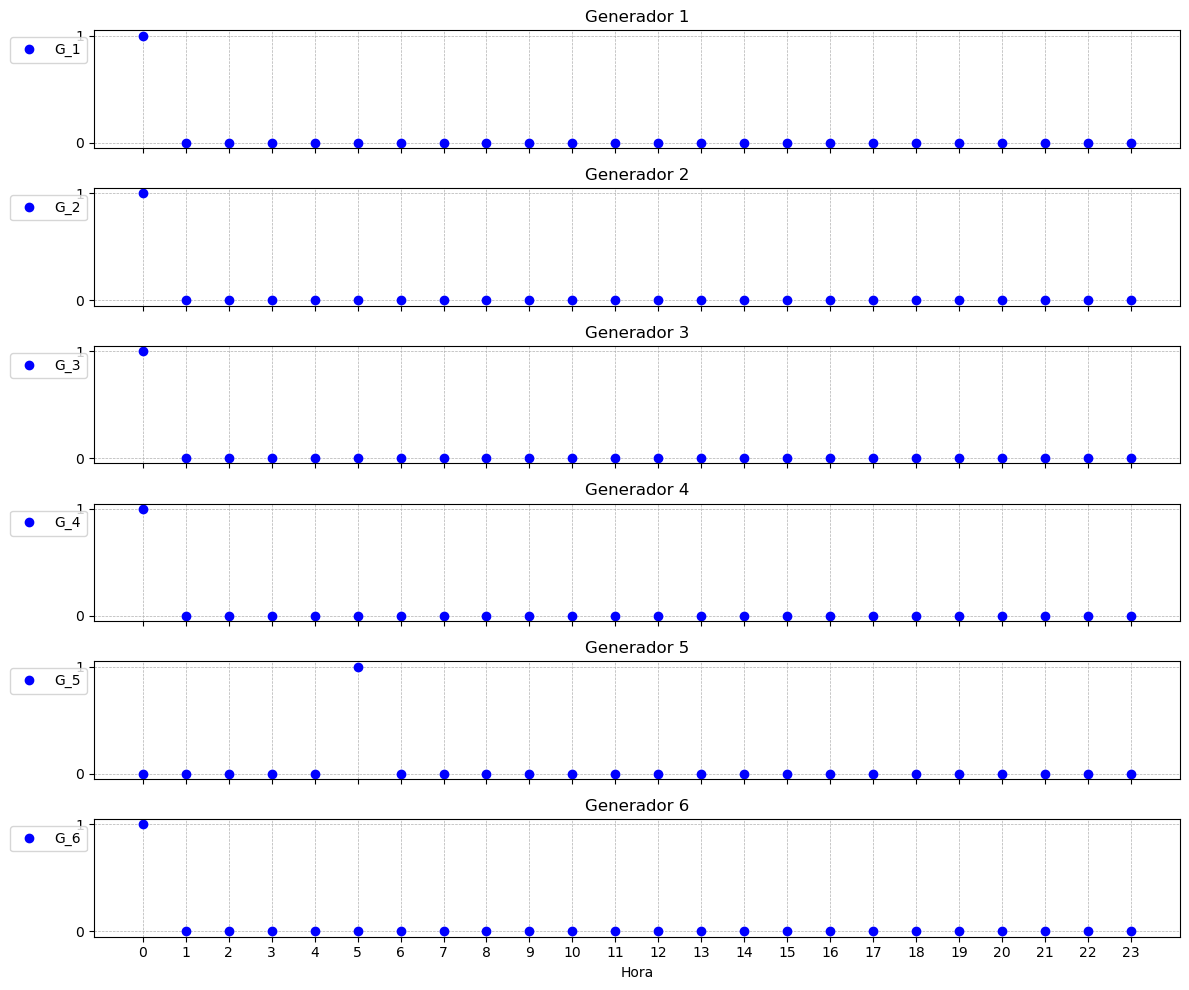

In [65]:
#Variable binaria x_ON

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_F.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_ON = df_resultados3[[f"X_ON_{generador}"]]

    # Graficar el flujo
    ax.plot(df_X_ON, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])


# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

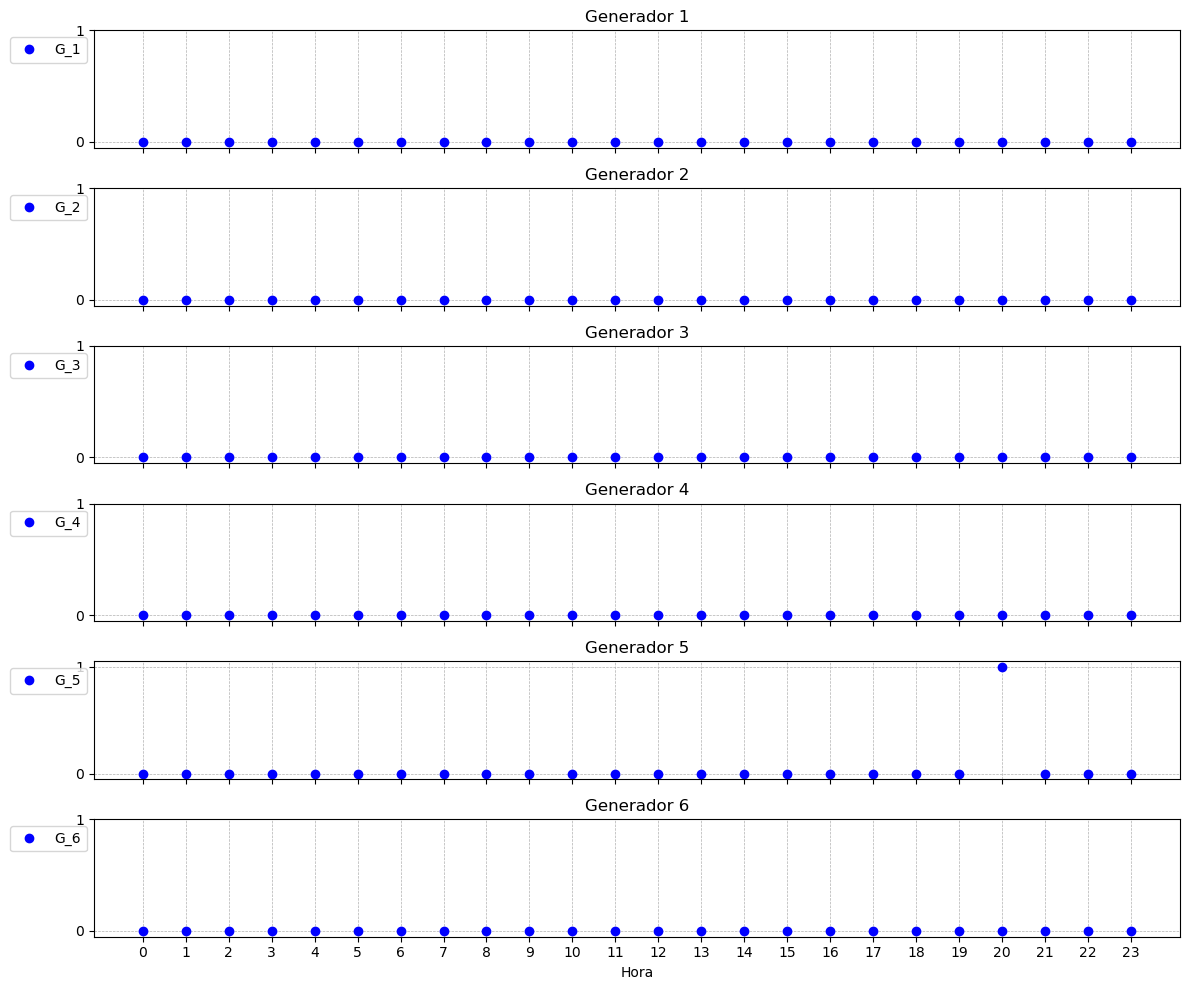

In [66]:
#Variable binaria x_OFF

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_F.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_OFF = df_resultados3[[f"X_OFF_{generador}"]]

    # Graficar
    ax.plot(df_X_OFF, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])


# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Binarias de estado

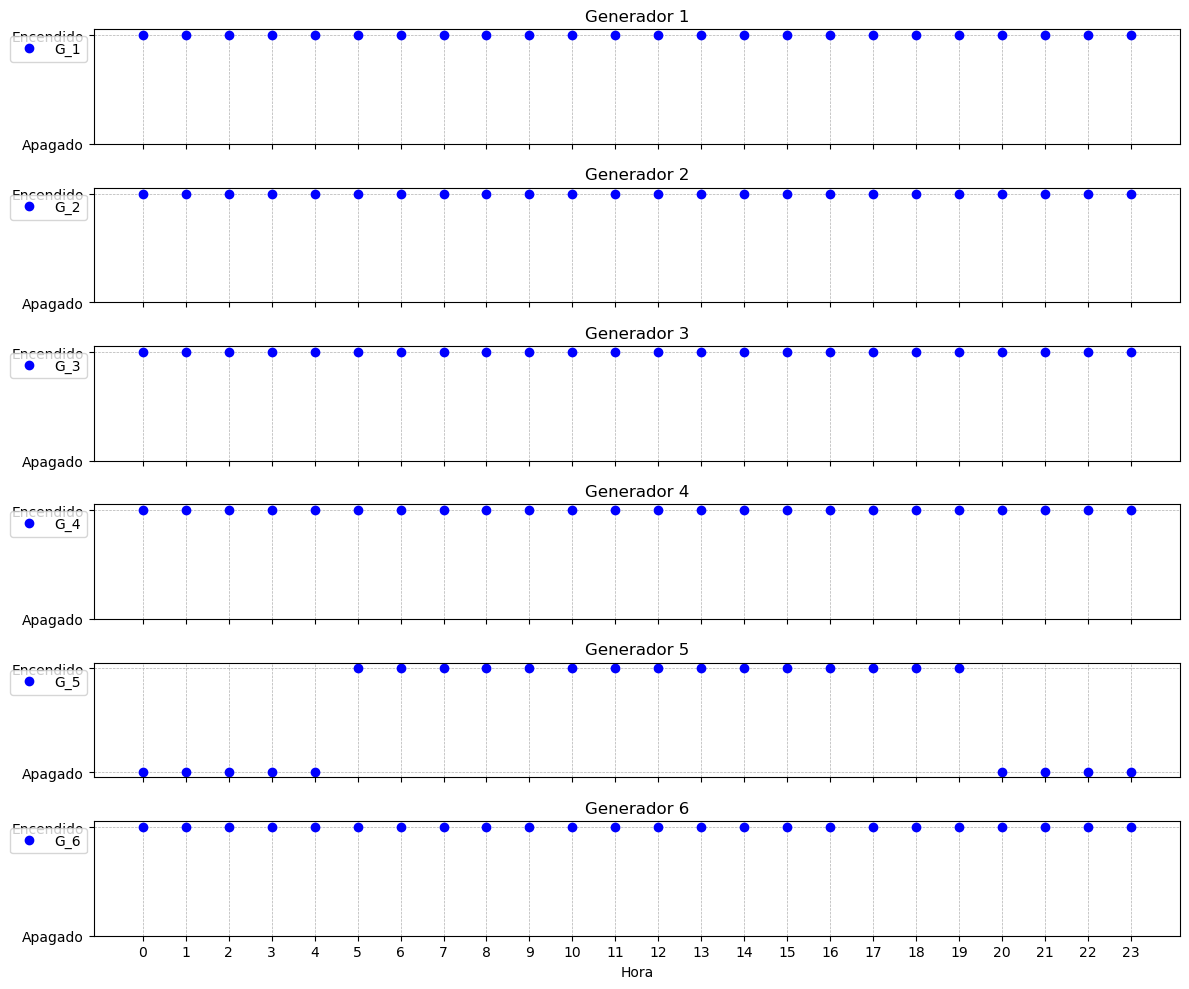

In [67]:
#Variable binaria de estado

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 10), sharex=True)


for i, generador in enumerate(m_F.Generadores):
    ax = axes[i]  # Seleccionar el eje correspondiente

    # Extraer datos para la línea i
    df_X_E = df_resultados3[[f"X_E_{generador}"]]

    # Graficar el flujo
    ax.plot(df_X_E, 'o', label=f"G_{generador}", color='b')

    ax.set_title(f"Generador {generador}")
    ax.legend(bbox_to_anchor=(0, 1))
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Apagado", "Encendido"])

# Configurar el eje X compartido
axes[-1].set_xlabel("Hora")
plt.xticks(range(0, 24, 1))  # Marcar cada 2 horas

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

## Respuestas a preguntas Parte F

No se observan diferencias entre el gráfico de demandas y el gráfico de áreas apiladas obtenido en esta parte. Tampoco se observan diferencias en la desición de encender/apagar generadores con respecto a la Parte D.

Por otro lado, se observa al graficar, que sí hay demanda no suminstrada. En particular, entre las horas 0 y 11.

Por último, Sí hay activación de la restricción de rampa, en particuar, al ver la tabla de resultados de la Parte D, se tiene que la diferencia de potencia generada por G_2 en las horas 12 y 13 es de 18.9 MW, lo cual incumple la restricción de rampa de subida para ese generador, la cual es de 16 MW. Al ver los mismos valores en la tabla de resultados de la Parte F, se tiene que la diferencia de potencia es de 15.6 MW, lo cual cumple la restricción de rampa.

In [68]:
#El valor optimo de la función objetivo obtenida para la parte F se muestra a continuación
print(m_F.obj())

1149620.8214310643


Se observa que el costo de la función objetivo es ligéramente mayor que el obtenido en las partes anterior, lo cual puede deberse a que el generador 4 debe suministrar más potencia durante la hora 13, pues, el generador 2 debe suminstrar menos en esa hora para cumplir la restricción de rampa. Por lo tanto, como el generador con costo variable más alto debe sumnistrar más potencia, se tiene que el valor optimo de la función objetivo aumenta.

Al buscar los valores en las tablas respectivas se observa que la hipotesis anterior es correcta, pues, en la tabla de resultados de la Parte D, se tiene que el generador 4 proporciona 10.9 MW, mientras que en la tabla de resultados de la Parte F, se tiene que el generador 4 proporciona 14.4 MW a la red.

# Parte G

Para el problema formulado en la **Parte E** y resuelto en la **Parte F**, proponga un aumento de capacidad para **sólo una línea o generador en 20 MW**, que reduzca el costo de la función objetivo en más de un 16%. Para demostrar que efectivamente existe una reducción, resuelva el problema usando el parámetro propuesto por usted.

Se elige aumentar la capacidad de la lina 4, pues al observar el gráfico obtenido en la Parte F, se tiene que la linea está la mayor parte del tiempo a máxima capacidad. Por lo tanto, L_4 tendrá una capacidad máxima, para efectos de esta parte, de 120 MW.


## Código Problema de Optmización

In [69]:
# Creación del modelo
m_G = ConcreteModel()


#Conjuntos
m_G.Barras      = Set(initialize=range(1,5))
m_G.Generadores = Set(initialize=Gens.ID.tolist())
m_G.Lineas      = Set(initialize=Lins.ID.tolist())
m_G.Horas       = Set(initialize=range(24))


#Parámetros
# Creación de diccionarios para acceder más fácilmente a los parámetros del problema
m_G.Pmax       = Param(m_G.Generadores, initialize=Gens.set_index("ID")["P_Max"].to_dict(), mutable=True) #Se vuelve al diccionario una estructura mutable
m_G.CV         = Param(m_G.Generadores, initialize=Gens.set_index("ID")["CV"].to_dict())
m_G.BarraGen   = Param(m_G.Generadores, initialize=Gens.set_index("ID")["Barra"].to_dict())
m_G.Fmax       = Param(m_G.Lineas, initialize=Lins.set_index("ID")["F_Max"].to_dict(), mutable=True) #Se vuelve al diccionario una estructura mutable
m_G.Reactancia = Param(m_G.Lineas, initialize=Lins.set_index("ID")["Reactancia"].to_dict())
m_G.From       = Param(m_G.Lineas, initialize=Lins.set_index("ID")["From"].to_dict())
m_G.To         = Param(m_G.Lineas, initialize=Lins.set_index("ID")["To"].to_dict())
m_G.Pmin       = Param(m_G.Generadores, initialize=Gens.set_index("ID")["P_Min"].to_dict())
m_G.Voll       = 1000

demanda_dict = {(b, h): Dems.loc[h, b] for h in range(24) for b in [1, 2, 3, 4]}
m_G.Demanda = Param(m_G.Barras, m_G.Horas, initialize=demanda_dict)

#Creamos una matriz de 6 x 24 para las potencias maximas disponibles entregadas por cada generador
Matrix_1 = np.ones(24, dtype=int)
PerSol = PerS.iloc[:, 0].values
PerEol = PerE.iloc[:, 0].values
Matrix_2 = [Matrix_1, Matrix_1, Matrix_1, Matrix_1, PerSol, PerEol]
disp = pd.DataFrame(Matrix_2, index=range(1,7))
#Ahora hagamos el dccionario para el modelo
disp_dict = {(g, h): disp.loc[g, h] for h in range(24) for g in [1, 2, 3, 4, 5, 6]}
m_G.Disponibilidad = Param(m_G.Generadores, m_G.Horas, initialize=disp_dict)

#Costos fijos de los generadores al encenderse y apagarse
m_G.C_E = Param(m_G.Generadores, initialize=Gens.set_index("ID")["C_on"].to_dict())
m_G.C_A = Param(m_G.Generadores, initialize=Gens.set_index("ID")["C_off"].to_dict())

#Valores de rampa de subida y bajada
m_G.R_UP = Param(m_G.Generadores, initialize=Gens.set_index("ID")["R_up"].to_dict())
m_G.R_DOWN = Param(m_G.Generadores, initialize=Gens.set_index("ID")["R_down"].to_dict())


# Variables
m_G.Pgen   = Var(m_G.Generadores, m_G.Horas, within=NonNegativeReals)
m_G.Flujo  = Var(m_G.Lineas, m_G.Horas, within=Reals)
m_G.Angulo = Var(m_G.Barras, m_G.Horas, within=Reals, bounds=(-3.14, 3.14))
m_G.Dns    = Var(m_G.Barras, m_G.Horas, within=NonNegativeReals)
m_G.X_ON   = Var(m_G.Generadores, m_G.Horas, within=Binary)
m_G.X_OFF  = Var(m_G.Generadores, m_G.Horas, within=Binary)
m_G.X_E    = Var(m_G.Generadores, m_G.Horas, within=Binary)


# Función objetivo: Minimizar costos de operación
m_G.obj =Objective(expr=sum(m_G.Pgen[g, t] * m_G.CV[g] + m_G.X_ON[g, t] * m_G.C_E[g] + m_G.X_OFF[g, t] * m_G.C_A[g]  for g in m_G.Generadores for t in m_G.Horas) + sum(m_G.Dns[b, t] * m_G.Voll for b in m_G.Barras for t in m_G.Horas), sense=minimize)


#Restricciones
#Restricción de balance de potencia
def balance_rule(m_G, b, t):
    return (sum(m_G.Pgen[g, t]  for g in m_G.Generadores if m_G.BarraGen[g] == b)
          - sum(m_G.Flujo[l, t] for l in m_G.Lineas if m_G.To[l] == b)
          + sum(m_G.Flujo[l, t] for l in m_G.Lineas if m_G.From[l] == b)
          + m_G.Dns[b, t]
          == m_G.Demanda[b, t])

m_G.Balance = Constraint(m_G.Barras, m_G.Horas, rule=balance_rule)

#Restricciones de generación
def gen_max_rule(m_G, g, t):
    return m_G.Pgen[g, t] <= m_G.Pmax[g] * m_G.Disponibilidad[g, t] * m_G.X_E[g, t]
m_G.GenMax = Constraint(m_G.Generadores, m_G.Horas, rule=gen_max_rule)

def gen_min_rule(m_G, g, t):
    return m_G.Pgen[g, t] >= m_G.Pmin[g] * m_G.X_E[g, t]
m_G.GenMin = Constraint(m_G.Generadores, m_G.Horas, rule=gen_min_rule)

# Restricciones de flujo en líneas
def flujo_max_rule(m_G, l, t):
    return m_G.Flujo[l, t] <= m_G.Fmax[l]
m_G.FlujoMax = Constraint(m_G.Lineas, m_G.Horas, rule=flujo_max_rule)

def flujo_min_rule(m_G, l, t):
    return m_G.Flujo[l, t] >= -m_G.Fmax[l]
m_G.FlujoMin = Constraint(m_G.Lineas, m_G.Horas, rule=flujo_min_rule)

# Restricción de flujo en función de los ángulos
def flujo_rule(m_G, l, t):
    return m_G.Flujo[l, t] * m_G.Reactancia[l] == m_G.Angulo[m_G.From[l], t] - m_G.Angulo[m_G.To[l], t]
m_G.FlujoEq = Constraint(m_G.Lineas, m_G.Horas, rule=flujo_rule)

#Restricción generador no produce si está apagado
def gen_on_off_rule(m_G, g, t):
    return m_G.Pgen[g, t] <= m_G.Pmax[g] * m_G.X_E[g, t]
m_G.GenOnOff = Constraint(m_G.Generadores, m_G.Horas, rule=gen_on_off_rule)

#Restricciones de conmutación de generadores
def conmutacion_rule1(m_G, g, t):
    if t > 0:
        return m_G.X_E[g, t] - m_G.X_E[g, t-1] == m_G.X_ON[g, t] - m_G.X_OFF[g, t]
    else:
        return m_G.X_E[g, t] == m_G.X_ON[g, t] - m_G.X_OFF[g, t]
m_G.Conmutacion1 = Constraint(m_G.Generadores, m_G.Horas, rule=conmutacion_rule1)

def conmutacion_rule2(m_G, g, t):
    return m_G.X_ON[g, t] + m_G.X_OFF[g, t] <= 1

m_G.Conmutacion2 = Constraint(m_G.Generadores, m_G.Horas, rule=conmutacion_rule2)


#Restricciones de rampa
def rampa_up_rule(m_G, g, t):
    if t < 23:
        return m_G.Pgen[g, t+1] - m_G.Pgen[g, t] <= m_G.R_UP[g] * m_G.X_E[g, t]
    else:
        return Constraint.Skip
m_G.RampaUp = Constraint(m_G.Generadores, m_G.Horas, rule=rampa_up_rule)

def rampa_down_rule(m_G, g, t):
    if t < 23:
        return m_G.Pgen[g, t] - m_G.Pgen[g, t+1] <= m_G.R_DOWN[g] * m_G.X_E[g, t]
    else:
        return Constraint.Skip
m_G.RampaDown = Constraint(m_G.Generadores, m_G.Horas, rule=rampa_down_rule)


## Modificación de la capacidad de generación y resultados

In [70]:
#Se aumenta la capacidad de la linea 4
m_G.Fmax[4] = 120

Se resuelve el problema

In [71]:
solver = SolverFactory('glpk')
solver.solve(m_G, tee=False)
print(f"Valor óptimo de la función objetivo = {m_G.obj()} ")

Valor óptimo de la función objetivo = 963429.1405413394 


In [72]:
Porcentaje = (1 - m_G.obj()/m_F.obj()) * 100

print(Porcentaje)

16.195921074041685


Se concluye que al aumentar la capacidad de la linea 4 en 20 MW, se obtiene una reducción del costo del 16.2%